## Trying k-prototype to classify the respondents: 

https://antonsruberts.github.io/kproto-audience/

- Reason for error in CO2 total during the power transformation: https://github.com/scikit-learn/scikit-learn/issues/14959
- Debugging: https://github.com/lmcinnes/umap/issues/561
- Reading for understanding K-prototype: https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb
- Another reading for K-prototype: https://zachary-a-zazueta.medium.com/k-prototypes-clustering-for-when-youre-clustering-continuous-and-categorical-data-6ea42c2ab2b9
- For visualizing elbow plot and analyze the clustering results: https://towardsdatascience.com/the-easiest-way-to-interpret-clustering-result-8137e488a127
- Reading for SHAP value: https://medium.com/@corymaklin/shap-shapley-additive-explanations-b8f0fce06202
- SHAP value documentation:https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html


- UMAP readings: 

https://towardsdatascience.com/umap-dimensionality-reduction-an-incredibly-robust-machine-learning-algorithm-b5acb01de568

https://www.linkedin.com/pulse/one-minute-overview-umap-algorithm-saulius-dobilas/

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes

from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score


C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading the final cleaned dataset with extended variables 

df = pd.read_csv('data_cleaned_descriptive_analysis_final.csv', header = 0)

pd.set_option('display.max_columns', None)
df.head(9)

Unnamed: 0  no_cars    gender  age  income       political_party  \
0          25      1.0  Weiblich   65  3000.0               CDU/CSU   
1          26      2.0  Weiblich   59   800.0          Keine Angabe   
2          27      0.0  Weiblich   60  1750.0          Keine Angabe   
3          28      1.0  Männlich   73  2500.0                   SPD   
4          30      0.0  Männlich   43  2500.0  Einer anderen Partei   
5          31      1.0  Weiblich   49  2300.0               CDU/CSU   
6          32      1.0  Weiblich   57   600.0               CDU/CSU   
7          33      2.0  Männlich   39  5000.0                   SPD   
8          34      2.0  Männlich   62     0.0          Keine Angabe   

                                           education  postal_code EUROSTAT  \
0  (Fach-) Hochschulabschluss (Bachelor, Master, ...        66440       PU   
1  Allgemeine oder fachgebundene Hochschulreife/A...        65933       PU   
2  Berufsausbildung, Lehre oder Ausbildung an ein...        95028       IN   
3  Realschulabschluss (Mittlere Reife) oder gleic...        63741       IN   
4  Berufsausbildung, Lehre oder Ausbildung an ein...        13059       PU   
5  Berufsausbildung, Lehre oder Ausbildung an ein...        39112       IN   
6  Realschulabschluss (Mittlere Reife) oder gleic...        78244       IN   
7  (Fach-) Hochschulabschluss (Bachelor, Master, ...        10115       PU   
8  (Fach-) Hochschulabschluss (Bachelor, Master, ...        46149       PU   

        RLK2022                                    KTU2022  \
0       zentral                          Städtischer Kreis   
1  sehr zentral                       kreisfreie Großstadt   
2      peripher  Ländlicher Kreis mit Verdichtungsansätzen   
3  sehr zentral                          Städtischer Kreis   
4  sehr zentral                       kreisfreie Großstadt   
5       zentral                       kreisfreie Großstadt   
6       zentral                          Städtischer Kreis   
7  sehr zentral                       kreisfreie Großstadt   
8  sehr zentral                       kreisfreie Großstadt   

         federal_state      NUTS2_NAME                           NUTS3_NAME  \
0             Saarland        Saarland                      Saarpfalz-Kreis   
1               Hessen       Darmstadt  Frankfurt am Main, Kreisfreie Stadt   
2               Bayern     Oberfranken                Hof, Kreisfreie Stadt   
3               Bayern    Unterfranken      Aschaffenburg, Kreisfreie Stadt   
4               Berlin          Berlin                               Berlin   
5       Sachsen-Anhalt  Sachsen-Anhalt          Magdeburg, Kreisfreie Stadt   
6    Baden-Württemberg        Freiburg                             Konstanz   
7               Berlin          Berlin                               Berlin   
8  Nordrhein-Westfalen      Düsseldorf         Oberhausen, Kreisfreie Stadt   

   CO2_housing  CO2_electricity  CO2_housing_electricity  CO2_cruise  \
0   5038.20000         1053.000               6091.20000         0.0   
1   1785.00000          487.500               2272.50000      2710.0   
2    200.10240          663.000                863.10240         0.0   
3    648.48000          975.000               1623.48000         0.0   
4   1923.48625          390.000               2313.48625         0.0   
5   2793.09600          663.000               3456.09600         0.0   
6   1620.00000          112.000               1732.00000         0.0   
7    902.67450           26.320                928.99450      4878.0   
8   2340.00000          825.825               3165.82500         0.0   

   CO2_flight  CO2_public_transport   CO2_car1  CO2_car2  CO2_car3  CO2_car4  \
0      2440.0                   0.0  1432.7280     0.000       0.0       0.0   
1      5985.0                 107.8  1944.6075  1037.124       0.0       0.0   
2       598.5                 107.8     0.0000     0.000       0.0       0.0   
3      2287.6                   0.0  1432.7280     0.000  

In [3]:
df.columns

Index(['Unnamed: 0', 'no_cars', 'gender', 'age', 'income', 'political_party',
       'education', 'postal_code', 'EUROSTAT', 'RLK2022', 'KTU2022',
       'federal_state', 'NUTS2_NAME', 'NUTS3_NAME', 'CO2_housing',
       'CO2_electricity', 'CO2_housing_electricity', 'CO2_cruise',
       'CO2_flight', 'CO2_public_transport', 'CO2_car1', 'CO2_car2',
       'CO2_car3', 'CO2_car4', 'CO2_car5', 'CO2_car_total', 'CO2_mobility',
       'CO2_food', 'CO2_other_consumption', 'public_emission', 'CO2_total',
       'belief_housing_electricity', 'belief_mobility', 'belief_food',
       'belief_other_consumption', 'belief_total',
       'actual_rank_CO2_housing_electricity1', 'actual_rank_CO2_mobility1',
       'actual_rank_CO2_food1', 'actual_rank_CO2_other_consumption1',
       'actual_rank_CO2_total1', 'actual_rank_CO2_housing_electricity2',
       'actual_rank_CO2_mobility2', 'actual_rank_CO2_food2',
       'actual_rank_CO2_other_consumption2', 'actual_rank_CO2_total2',
       'belief_diff_housi

In [4]:
df2 = df[['age','income', 'RLK2022', 'no_cars',
          'CO2_cruise', 'CO2_flight', 'CO2_public_transport','CO2_car_total', 'belief_diff_mobility']]

In [5]:
### Change column name: 'RLK2022' will be named as urban_rural_class as it is the variable used for modeling

df2 = df2.rename(columns={'RLK2022':'urban_rural_class'})

In [6]:
df2.dtypes

age                       int64
income                  float64
urban_rural_class        object
no_cars                 float64
CO2_cruise              float64
CO2_flight              float64
CO2_public_transport    float64
CO2_car_total           float64
belief_diff_mobility    float64
dtype: object

## Dimension Reduction using UMAP

In [7]:
# Setting the graph style
sns.set(font_scale = 2)
sns.set_style("ticks")

In [8]:
#Preprocessing numerical

np.random.seed(123)

numerical = df2.select_dtypes(exclude='object')

for c in numerical.columns:
    scaler = StandardScaler(with_std=False)
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    temp_array = scaler.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    numerical.loc[:, c] = pt.fit_transform(temp_array)
    
##preprocessing categorical
categorical = df2.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df2.select_dtypes(include='object').columns) / df2.shape[1]

#Embedding numerical & categorical 
fit1 = umap.UMAP(metric='l2').fit(numerical) # euclidean
fit2 = umap.UMAP(metric='dice').fit(categorical)



C:\Users\leajo\AppData\Roaming\Python\Python39\site-packages\umap\umap_.py:1879: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  warn(


C:\Users\leajo\AppData\Local\Temp\ipykernel_20380\2483902116.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(*np.array(embedding)[0].T, s=20, cmap='Spectral', alpha=1.0)


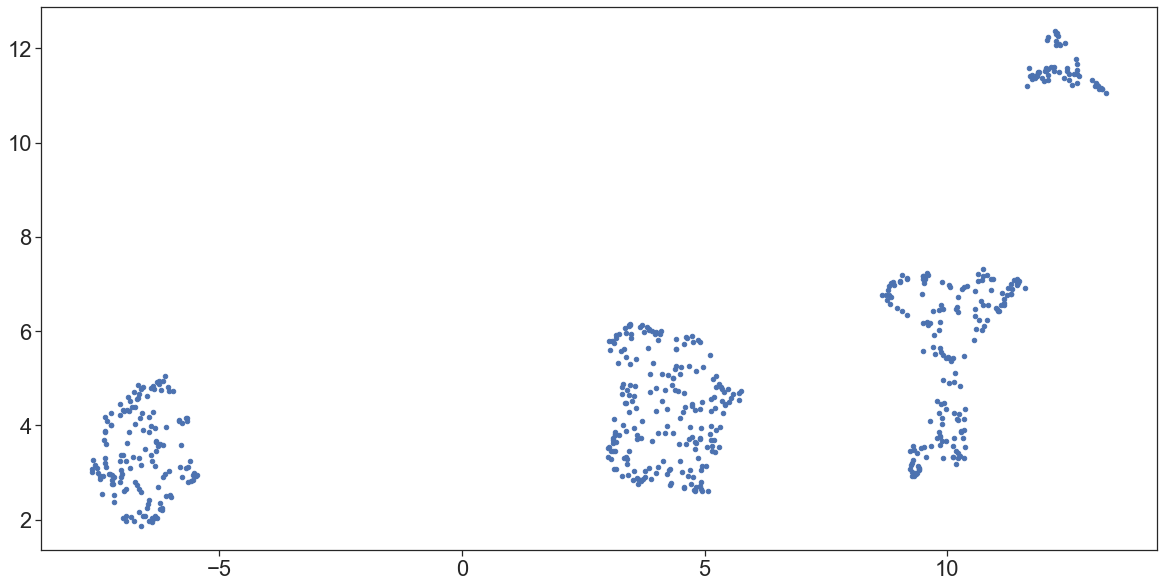

In [9]:
#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components,
                                                fit1._initial_alpha, fit1._a, fit1._b,
                                                fit1.repulsion_strength, fit1.negative_sample_rate,
                                                200, 'random', np.random, fit1.metric,
                                                fit1._metric_kwds, False, {}, False)

plt.figure(figsize=(20, 10))
plt.scatter(*np.array(embedding)[0].T, s=20, cmap='Spectral', alpha=1.0)
plt.show()

## K-prototype Clustering

- **IMPORTANT :** Before running this part, initialize UMAP first so that the UMAP does not take K-Prototype clusters as input.
- “distance” calculated is simply the number of disagreements between each data point and cluster mode centroid.

In [10]:
## Preparing the data by power transformation

kprot_data = df2.copy()

for c in df2.select_dtypes(exclude='object').columns:
    scaler = StandardScaler(with_std=False)
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    temp_array = scaler.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))
    kprot_data[c] =  pt.fit_transform(temp_array)
    

In [11]:
# Elbow plot with cost

costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 30)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=[2])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs))
fig.show();

  0%|                                                                                           | 0/28 [00:00<?, ?it/s]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 126, ncost: 3829.635770367964
Run: 1, iteration: 2/100, moves: 47, ncost: 3790.8851035164935
Run: 1, iteration: 3/100, moves: 16, ncost: 3781.767936287355
Run: 1, iteration: 4/100, moves: 4, ncost: 3781.361609354872
Run: 1, iteration: 5/100, moves: 2, ncost: 3781.27290379503
Run: 1, iteration: 6/100, moves: 0, ncost: 3781.27290379503
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 85, ncost: 3795.729464601106
Run: 2, iteration: 2/100, moves: 26, ncost: 3782.496790667561
Run: 2, iteration: 3/100, moves: 4, ncost: 3781.7910167373316
Run: 2, iteration: 4/100, moves: 1, ncost: 3781.7030954049055
Run: 2, iteration: 5/100, moves: 1, ncost: 3781.62909010902
Run: 2, iteration: 6/100, moves: 0, ncost: 3781.62909010902
Init: initializing centroid

  4%|██▉                                                                                | 1/28 [00:02<01:06,  2.48s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 178, ncost: 3685.039290532183
Run: 1, iteration: 2/100, moves: 117, ncost: 3443.9955444395164
Run: 1, iteration: 3/100, moves: 45, ncost: 3391.503063779744
Run: 1, iteration: 4/100, moves: 51, ncost: 3340.7716302085787
Run: 1, iteration: 5/100, moves: 36, ncost: 3315.631978690997
Run: 1, iteration: 6/100, moves: 28, ncost: 3291.4950628106017
Run: 1, iteration: 7/100, moves: 26, ncost: 3277.08746336294
Run: 1, iteration: 8/100, moves: 21, ncost: 3268.2094837134905
Run: 1, iteration: 9/100, moves: 14, ncost: 3263.4010871579417
Run: 1, iteration: 10/100, moves: 11, ncost: 3259.905700602984
Run: 1, iteration: 11/100, moves: 6, ncost: 3258.3623926534524
Run: 1, iteration: 12/100, moves: 1, ncost: 3258.1940072818516
Run: 1, iteration: 13/100, moves: 3, ncost: 3257.989398276982
Run: 1, iteration: 14/100, mo

  7%|█████▉                                                                             | 2/28 [00:06<01:25,  3.30s/it]

Run: 10, iteration: 6/100, moves: 0, ncost: 3241.325444142386
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 202, ncost: 3029.294484434544
Run: 1, iteration: 2/100, moves: 83, ncost: 2890.805199840289
Run: 1, iteration: 3/100, moves: 47, ncost: 2762.845025892329
Run: 1, iteration: 4/100, moves: 11, ncost: 2756.4864303834624
Run: 1, iteration: 5/100, moves: 0, ncost: 2756.4864303834624
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 188, ncost: 3229.2151058667278
Run: 2, iteration: 2/100, moves: 92, ncost: 3105.9202486211116
Run: 2, iteration: 3/100, moves: 84, ncost: 3013.193831405395
Run: 2, iteration: 4/100, moves: 58, ncost: 2967.2286772973252
Run: 2, iteration: 5/100, moves: 38, ncost: 2948.346488585295
Run: 2, iteration: 6/100, moves: 15, ncost: 2944.46818

 11%|████████▉                                                                          | 3/28 [00:09<01:18,  3.14s/it]

Run: 10, iteration: 9/100, moves: 0, ncost: 2821.7105824001696
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 198, ncost: 2710.1415726471796
Run: 1, iteration: 2/100, moves: 75, ncost: 2578.3501021501784
Run: 1, iteration: 3/100, moves: 25, ncost: 2565.0610345559376
Run: 1, iteration: 4/100, moves: 9, ncost: 2562.457813876474
Run: 1, iteration: 5/100, moves: 1, ncost: 2562.2272148196744
Run: 1, iteration: 6/100, moves: 1, ncost: 2562.095793269721
Run: 1, iteration: 7/100, moves: 1, ncost: 2561.8574658097177
Run: 1, iteration: 8/100, moves: 0, ncost: 2561.8574658097177
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 227, ncost: 2904.5935200503045
Run: 2, iteration: 2/100, moves: 73, ncost: 2847.4686736035765
Run: 2, iteration: 3/100, moves: 51, ncost: 2815.42330

 14%|███████████▊                                                                       | 4/28 [00:12<01:15,  3.14s/it]

Run: 10, iteration: 10/100, moves: 4, ncost: 2552.609963221593
Run: 10, iteration: 11/100, moves: 0, ncost: 2552.609963221593
Best run was number 4
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 177, ncost: 2605.4186767536426
Run: 1, iteration: 2/100, moves: 70, ncost: 2529.471344176144
Run: 1, iteration: 3/100, moves: 41, ncost: 2481.4008342732404
Run: 1, iteration: 4/100, moves: 29, ncost: 2466.0900857636466
Run: 1, iteration: 5/100, moves: 11, ncost: 2463.793304381402
Run: 1, iteration: 6/100, moves: 3, ncost: 2463.0703502561623
Run: 1, iteration: 7/100, moves: 6, ncost: 2461.7114119381536
Run: 1, iteration: 8/100, moves: 1, ncost: 2461.6202784032866
Run: 1, iteration: 9/100, moves: 0, ncost: 2461.6202784032866
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 188, ncost: 2591.0909

 18%|██████████████▊                                                                    | 5/28 [00:16<01:19,  3.46s/it]

Run: 10, iteration: 18/100, moves: 1, ncost: 2328.211875342115
Run: 10, iteration: 19/100, moves: 1, ncost: 2327.9916231271
Run: 10, iteration: 20/100, moves: 1, ncost: 2327.793849619139
Run: 10, iteration: 21/100, moves: 0, ncost: 2327.793849619139
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 156, ncost: 2345.6851655309965
Run: 1, iteration: 2/100, moves: 76, ncost: 2241.4438044804765
Run: 1, iteration: 3/100, moves: 32, ncost: 2222.867522369947
Run: 1, iteration: 4/100, moves: 11, ncost: 2219.5227260525726
Run: 1, iteration: 5/100, moves: 10, ncost: 2215.5081479003184
Run: 1, iteration: 6/100, moves: 8, ncost: 2212.480622870226
Run: 1, iteration: 7/100, moves: 8, ncost: 2210.0473877550994
Run: 1, iteration: 8/100, moves: 1, ncost: 2209.8789874574727
Run: 1, iteration: 9/100, moves: 0, ncost: 2209.8789874574727
Init: ini

 21%|█████████████████▊                                                                 | 6/28 [00:20<01:20,  3.66s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 191, ncost: 2471.866680083722
Run: 1, iteration: 2/100, moves: 94, ncost: 2259.317004562896
Run: 1, iteration: 3/100, moves: 37, ncost: 2180.9850257176754
Run: 1, iteration: 4/100, moves: 15, ncost: 2160.3606521106826
Run: 1, iteration: 5/100, moves: 4, ncost: 2157.280391237479
Run: 1, iteration: 6/100, moves: 2, ncost: 2156.425780400973
Run: 1, iteration: 7/100, moves: 0, ncost: 2156.425780400973
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 209, ncost: 2307.784298902759
Run: 2, iteration: 2/100, moves: 95, ncost: 2177.3574267629447
Run: 2, iteration: 3/100, moves: 38, ncost: 2158.0373149694233
Run: 2, iteration: 4/100, moves: 17, ncost: 2151.1085245733143
Run: 2, iteration: 5/100, moves: 15, ncost: 2146.8392675261284
Run: 2, iterati

 25%|████████████████████▊                                                              | 7/28 [00:23<01:13,  3.49s/it]

Run: 10, iteration: 10/100, moves: 0, ncost: 2138.313646189608
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 156, ncost: 2222.389177744337
Run: 1, iteration: 2/100, moves: 70, ncost: 2135.9573552778857
Run: 1, iteration: 3/100, moves: 31, ncost: 2118.2803788313686
Run: 1, iteration: 4/100, moves: 27, ncost: 2101.8871200846047
Run: 1, iteration: 5/100, moves: 30, ncost: 2077.503574239824
Run: 1, iteration: 6/100, moves: 20, ncost: 2066.214241612235
Run: 1, iteration: 7/100, moves: 16, ncost: 2059.938176334295
Run: 1, iteration: 8/100, moves: 12, ncost: 2053.057427537317
Run: 1, iteration: 9/100, moves: 14, ncost: 2046.0085018139412
Run: 1, iteration: 10/100, moves: 3, ncost: 2045.5364095622033
Run: 1, iteration: 11/100, moves: 3, ncost: 2044.4982530672526
Run: 1, iteration: 12/100, moves: 10, ncost: 2039.9960266434614
Run: 1

 29%|███████████████████████▋                                                           | 8/28 [00:28<01:15,  3.80s/it]

Run: 10, iteration: 4/100, moves: 53, ncost: 2027.6770902127455
Run: 10, iteration: 5/100, moves: 27, ncost: 2012.8146438595124
Run: 10, iteration: 6/100, moves: 8, ncost: 2011.654002351474
Run: 10, iteration: 7/100, moves: 0, ncost: 2011.654002351474
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 244, ncost: 2088.8044474935286
Run: 1, iteration: 2/100, moves: 93, ncost: 1994.599857683471
Run: 1, iteration: 3/100, moves: 23, ncost: 1976.0841308776246
Run: 1, iteration: 4/100, moves: 18, ncost: 1965.8787538472366
Run: 1, iteration: 5/100, moves: 9, ncost: 1963.72039692096
Run: 1, iteration: 6/100, moves: 2, ncost: 1963.0153498680518
Run: 1, iteration: 7/100, moves: 3, ncost: 1962.4657478450074
Run: 1, iteration: 8/100, moves: 1, ncost: 1962.246880019645
Run: 1, iteratio

 32%|██████████████████████████▋                                                        | 9/28 [00:32<01:15,  3.95s/it]

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 199, ncost: 2005.9182827062941
Run: 1, iteration: 2/100, moves: 80, ncost: 1919.3177704701293
Run: 1, iteration: 3/100, moves: 54, ncost: 1877.6463189191345
Run: 1, iteration: 4/100, moves: 13, ncost: 1873.4686245280857
Run: 1, iteration: 5/100, moves: 4, ncost: 1872.8701110476486
Run: 1, iteration: 6/100, moves: 0, ncost: 1872.8701110476486
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 240, ncost: 2006.1173543341024
Run: 2, iteration: 2/100, moves: 80, ncost: 1952.8012380815876
Run: 2, iteration: 3/100, moves: 24, ncost: 1942.0718925245571
Run: 2, iteration: 4/100, moves: 16, ncost: 1933.391209468016
Run: 2, iteration: 5/100, moves: 5, ncost: 1931.463797962689
Run: 2, iteration: 6/100, moves: 14, ncost: 1923.5529070285563
Run: 2, ite

 36%|█████████████████████████████▎                                                    | 10/28 [00:35<01:06,  3.69s/it]

Run: 10, iteration: 5/100, moves: 33, ncost: 1859.3465879557048
Run: 10, iteration: 6/100, moves: 22, ncost: 1845.7866701548717
Run: 10, iteration: 7/100, moves: 13, ncost: 1842.3672411751868
Run: 10, iteration: 8/100, moves: 4, ncost: 1841.317246603828
Run: 10, iteration: 9/100, moves: 0, ncost: 1841.317246603828
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 236, ncost: 1936.5278071644943
Run: 1, iteration: 2/100, moves: 80, ncost: 1861.6522125656056
Run: 1, iteration: 3/100, moves: 31, ncost: 1841.1769403248722
Run: 1, iteration: 4/100, moves: 13, ncost: 1836.9536557015383
Run: 1, iteration: 5/100, moves: 10, ncost: 1832.6233378387412
Run: 1, iteration: 6/100, moves: 0, ncost: 1832.6233378387412
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 239, ncost: 191

 39%|████████████████████████████████▏                                                 | 11/28 [00:38<01:00,  3.59s/it]

Run: 10, iteration: 7/100, moves: 11, ncost: 1775.0110293051648
Run: 10, iteration: 8/100, moves: 6, ncost: 1773.8003410322797
Run: 10, iteration: 9/100, moves: 1, ncost: 1773.467802993478
Run: 10, iteration: 10/100, moves: 0, ncost: 1773.467802993478
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 286, ncost: 1816.737680427098
Run: 1, iteration: 2/100, moves: 99, ncost: 1733.226340383958
Run: 1, iteration: 3/100, moves: 38, ncost: 1702.252486821136
Run: 1, iteration: 4/100, moves: 19, ncost: 1691.4995804675918
Run: 1, iteration: 5/100, moves: 9, ncost: 1689.675007427032
Run: 1, iteration: 6/100, moves: 3, ncost: 1689.2383694439168
Run: 1, iteration: 7/100, moves: 0, ncost: 1689.2383694439168
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations..

 43%|███████████████████████████████████▏                                              | 12/28 [00:42<00:56,  3.51s/it]

Run: 10, iteration: 5/100, moves: 3, ncost: 1779.687818679421
Run: 10, iteration: 6/100, moves: 0, ncost: 1779.687818679421
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 214, ncost: 1792.067080534253
Run: 1, iteration: 2/100, moves: 85, ncost: 1713.8954620088655
Run: 1, iteration: 3/100, moves: 46, ncost: 1675.8841747056088
Run: 1, iteration: 4/100, moves: 15, ncost: 1669.4757174097062
Run: 1, iteration: 5/100, moves: 8, ncost: 1667.4050015637008
Run: 1, iteration: 6/100, moves: 1, ncost: 1667.1539557703386
Run: 1, iteration: 7/100, moves: 0, ncost: 1667.1539557703386
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 293, ncost: 1953.3732788575028
Ru

 46%|██████████████████████████████████████                                            | 13/28 [00:45<00:51,  3.42s/it]

Run: 10, iteration: 12/100, moves: 5, ncost: 1612.7449095440238
Run: 10, iteration: 13/100, moves: 3, ncost: 1611.3621656849923
Run: 10, iteration: 14/100, moves: 6, ncost: 1607.8275925895307
Run: 10, iteration: 15/100, moves: 2, ncost: 1607.1577698934634
Run: 10, iteration: 16/100, moves: 0, ncost: 1607.1577698934634
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 192, ncost: 1771.6853551926013
Run: 1, iteration: 2/100, moves: 54, ncost: 1730.1925419359306
Run: 1, iteration: 3/100, moves: 41, ncost: 1703.3316691475704
Run: 1, iteration: 4/100, moves: 23, ncost: 1691.3120725220385
Run: 1, iteration: 5/100, moves: 14, ncost: 1684.69577478263
Run: 1, iteration: 6/100, moves: 10, ncost: 1680.2517681705988
Run: 1, iteration: 7/100, moves: 8, ncost: 1677.2973259598816
Run: 

 50%|█████████████████████████████████████████                                         | 14/28 [00:48<00:46,  3.35s/it]

Run: 10, iteration: 3/100, moves: 66, ncost: 1614.4330171299698
Run: 10, iteration: 4/100, moves: 23, ncost: 1605.9653739788782
Run: 10, iteration: 5/100, moves: 21, ncost: 1597.9550817386607
Run: 10, iteration: 6/100, moves: 2, ncost: 1597.725863429754
Run: 10, iteration: 7/100, moves: 0, ncost: 1597.725863429754
Best run was number 7
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 179, ncost: 1680.9848868836705
Run: 1, iteration: 2/100, moves: 78, ncost: 1602.89843543491
Run: 1, iteration: 3/100, moves: 44, ncost: 1578.872852842594
Run: 1, iteration: 4/100, moves: 14, ncost: 1573.682342088004
Run: 1, iteration: 5/100, moves: 14, ncost: 1568.0843562642542
Run: 1, iteration: 6/100, moves: 7, ncost: 1566.1848845288898
Run: 1, iteration: 7/100, moves: 9, ncost: 1563.8604691343685
Run: 1, iteration: 8/100, moves: 10, ncost: 1561.2770013550605
Run: 1,

 54%|███████████████████████████████████████████▉                                      | 15/28 [00:51<00:41,  3.20s/it]

Run: 10, iteration: 2/100, moves: 100, ncost: 1602.8617626593239
Run: 10, iteration: 3/100, moves: 34, ncost: 1578.013312551054
Run: 10, iteration: 4/100, moves: 25, ncost: 1557.578025989121
Run: 10, iteration: 5/100, moves: 8, ncost: 1555.3258409634484
Run: 10, iteration: 6/100, moves: 0, ncost: 1555.3258409634484
Best run was number 5
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 264, ncost: 1654.2276935238676
Run: 1, iteration: 2/100, moves: 82, ncost: 1587.0008295008124
Run: 1, iteration: 3/100, moves: 33, ncost: 1565.9718337193553
Run: 1, iteration: 4/100, moves: 28, ncost: 1542.9377944516302
Run: 1, iteration: 5/100, moves: 22, ncost: 1531.0458973906827
Run: 1, iteration: 6/100, moves: 8, ncost: 1528.9506232665199
Run: 1, itera

 57%|██████████████████████████████████████████████▊                                   | 16/28 [00:55<00:40,  3.34s/it]

Run: 10, iteration: 6/100, moves: 3, ncost: 1622.916509154618
Run: 10, iteration: 7/100, moves: 5, ncost: 1619.9178156994187
Run: 10, iteration: 8/100, moves: 7, ncost: 1616.7983922647923
Run: 10, iteration: 9/100, moves: 5, ncost: 1615.5465958251662
Run: 10, iteration: 10/100, moves: 1, ncost: 1615.4202046073942
Run: 10, iteration: 11/100, moves: 0, ncost: 1615.4202046073942
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 228, ncost: 1664.8180605097432
Run: 1, iteration: 2/100, moves: 78, ncost: 1580.0705192904616
Run: 1, iteration: 3/100, moves: 55, ncost: 1525.5507041026522
Run: 1, iteration: 4/100, moves: 23, ncost: 1508.2021307894643
Run: 1, iteration: 5/100, moves: 9, ncost: 1503.922346296628
Run: 1, iteration: 6/100, moves: 13, ncost: 1493.662352853989
Run: 1, iteration: 7/100, moves: 13, ncost: 1480.3188779565567
Run:

 61%|█████████████████████████████████████████████████▊                                | 17/28 [00:58<00:38,  3.46s/it]

Run: 10, iteration: 6/100, moves: 28, ncost: 1452.1316409180574
Run: 10, iteration: 7/100, moves: 18, ncost: 1439.2951114065336
Run: 10, iteration: 8/100, moves: 4, ncost: 1438.6848049776645
Run: 10, iteration: 9/100, moves: 3, ncost: 1437.2333514701054
Run: 10, iteration: 10/100, moves: 1, ncost: 1437.0081201764133
Run: 10, iteration: 11/100, moves: 0, ncost: 1437.0081201764133
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 299, ncost: 1646.0379076008965
Run: 1, iteration: 2/100, moves: 

Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 265, ncost: 1561.4145772204438
Run: 9, iteration: 2/100, moves: 69, ncost: 1476.8546007264956
Run: 9, iteration: 3/100, moves: 29, ncost: 1463.0941615628487
Run: 9, iteration: 4/100, moves: 16, ncost: 1457.3535988562764
Run: 9, iteration: 5/100, moves: 18, ncost: 1450.04257270344
Run: 9, iteration: 6/100, moves: 6, ncost: 1448.1662697410175
Run: 9, iteration: 7/100, moves: 0, ncost: 1448.1662697410175
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 214, ncost: 1532.8780993176097


 64%|████████████████████████████████████████████████████▋                             | 18/28 [01:02<00:35,  3.58s/it]

Run: 10, iteration: 2/100, moves: 96, ncost: 1438.8036439480786
Run: 10, iteration: 3/100, moves: 24, ncost: 1425.33615684795
Run: 10, iteration: 4/100, moves: 15, ncost: 1417.3273609659113
Run: 10, iteration: 5/100, moves: 5, ncost: 1416.3326936173012
Run: 10, iteration: 6/100, moves: 1, ncost: 1415.9748246781535
Run: 10, iteration: 7/100, moves: 0, ncost: 1415.9748246781535
Best run was number 8
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 261, ncost: 1523.087280307396
Run: 1, iteration: 2/100, moves: 75, ncost: 1471.66980963255
Run: 1, iteration: 3/100, moves: 29, ncost: 1458.7007921162947
Run: 1, iteration: 4/100, moves: 17, ncost: 1453.3033255705623
Run: 1, iteration: 5/100, moves: 9, ncost: 1450.7303311351768
Run: 1, iteration: 6/100, moves: 2, ncost: 1450.385205449762
Run: 1, itera

 68%|███████████████████████████████████████████████████████▋                          | 19/28 [01:06<00:31,  3.55s/it]

Run: 10, iteration: 4/100, moves: 12, ncost: 1384.7300772323651
Run: 10, iteration: 5/100, moves: 2, ncost: 1384.0321678424343
Run: 10, iteration: 6/100, moves: 1, ncost: 1383.7414847782832
Run: 10, iteration: 7/100, moves: 0, ncost: 1383.7414847782832
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 215, ncost: 1478.2138187523724
Run: 1, iteration: 2/100, moves: 87, ncost: 1409.0466952835961
Run: 1, iteration: 3/100, moves: 43, ncost: 1380.875325037677
Run: 1, iteration: 4/100, moves: 27, ncost: 1362.171922237661
Run: 1, iteration: 5/100, moves: 9, ncost: 1358.905849568307
Run: 1, iteration: 6/100, moves: 9, ncost: 1355.8016709805647
Run: 1, iteration: 7/100, moves: 7, ncost: 1353.576408323832
Run: 1, iteration: 8/100, moves: 7, ncost: 1350.4746245387391
Run: 1, iterat

 71%|██████████████████████████████████████████████████████████▌                       | 20/28 [01:09<00:28,  3.54s/it]

Run: 10, iteration: 14/100, moves: 1, ncost: 1361.2129284514933
Run: 10, iteration: 15/100, moves: 0, ncost: 1361.2129284514933
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 196, ncost: 1516.9722018028863
Run: 1, iteration: 2/100, moves: 85, ncost: 1417.2410236273074
Run: 1, iteration: 3/100, moves: 47, ncost: 1395.7136902938569
Run: 1, iteration: 4/100, moves: 14, ncost: 1391.0378985235354
Run: 1, iteration: 5/100, moves: 1, ncost: 1390.901512669218
Run: 1, iteration: 6/100, moves: 0, ncost: 1390.901512669218
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 199, ncost: 1591.75070073785
Run: 2, iteration: 2/100, moves: 133, ncost: 1431.5242509305008
Run: 2, iteration: 3/100, moves: 52, ncost: 1402.8287666035142
Run: 2, iteration: 4/100, moves: 11, ncost: 1398.6

Run: 10, iteration: 2/100, moves: 65, ncost: 1428.1102246147248
Run: 10, iteration: 3/100, moves: 33, ncost: 1396.6679817637776
Run: 10, iteration: 4/100, moves: 17, ncost: 1383.3259374798297
Run: 10, iteration: 5/100, moves: 18, ncost: 1372.2587488249285
Run: 10, iteration: 6/100, moves: 5, ncost: 1371.0675179172913
Run: 10, iteration: 7/100, moves: 4, ncost: 1370.1328952337153
Run: 10, iteration: 8/100, moves: 3, ncost: 1369.2330045385454


 75%|█████████████████████████████████████████████████████████████▌                    | 21/28 [01:13<00:25,  3.70s/it]

Run: 10, iteration: 9/100, moves: 3, ncost: 1368.573068354638
Run: 10, iteration: 10/100, moves: 1, ncost: 1368.294087267323
Run: 10, iteration: 11/100, moves: 0, ncost: 1368.294087267323
Best run was number 7
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1,

 79%|████████████████████████████████████████████████████████████████▍                 | 22/28 [01:17<00:22,  3.69s/it]

Run: 10, iteration: 9/100, moves: 1, ncost: 1318.863242936461
Run: 10, iteration: 10/100, moves: 1, ncost: 1318.6096331519686
Run: 10, iteration: 11/100, moves: 0, ncost: 1318.6096331519686
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 226, ncost: 1380.069958435259
Run: 1, iteration: 2/100, moves: 81, ncost: 1308.219382034667
Run: 1, iteration: 3/100, moves: 34, ncost: 1286.6507271025584
Run: 1, iteration: 4/100, moves: 22, ncost: 1276.9004041724868
Run: 1, iteration: 5/100, moves: 11, ncost: 1273.662118935039
Run: 1, iteration: 6/100, moves: 9, ncost: 1267.7695636804513
Run: 1, iteration: 7/100, moves: 4, ncost: 1266.5788760653436
Run: 1, iteration: 8/100, moves: 6, ncost: 1264.2809359411824
Run: 1, iteration: 9/100, moves: 7, ncost: 1259.2055255978496
Run: 1, iterat

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 264

 82%|███████████████████████████████████████████████████████████████████▎              | 23/28 [01:21<00:19,  3.86s/it]

Run: 10, iteration: 6/100, moves: 0, ncost: 1307.906006474121
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 231, ncost: 1375.9406395785877
Run: 1, iteration: 2/100, moves: 90, ncost: 1293.9672321782432
Run: 1

Run: 7, iteration: 8/100, moves: 3, ncost: 1253.559177400871
Run: 7, iteration: 9/100, moves: 3, ncost: 1252.8431575562438
Run: 7, iteration: 10/100, moves: 5, ncost: 1250.9666185227652
Run: 7, iteration: 11/100, moves: 1, ncost: 1250.7155973167196
Run: 7, iteration: 12/100, moves: 0, ncost: 1250.7155973167196
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 218, ncost: 1417.9684717034793
Run: 8, iteration: 2/100, moves: 67, ncost: 1343.4375347885232
Run: 8, iteration: 3/100, moves: 38, ncost: 1310.5216010647528
Run: 8, iteration: 4/100, moves: 29, ncost: 1292.415638217348
Run: 8, iteration: 5/100, moves: 21, ncost: 1274.033237472297
Run: 8, iteration: 6/100, moves: 12, ncost: 1270.297705281068
Run: 8, iteration: 7/100, moves: 11, ncost: 1265.9770663237416
Run: 8, iteration: 8/100, moves: 7, ncost: 1264.1852089208815
Run: 8, iteration: 9/100, moves: 1, ncost: 1263.893012875564
Run: 8, iteration: 10/100, moves: 5, ncost: 12

 86%|██████████████████████████████████████████████████████████████████████▎           | 24/28 [01:27<00:17,  4.37s/it]

Run: 10, iteration: 3/100, moves: 34, ncost: 1345.76675581565
Run: 10, iteration: 4/100, moves: 30, ncost: 1329.9866424524866
Run: 10, iteration: 5/100, moves: 23, ncost: 1315.772044938794
Run: 10, iteration: 6/100, moves: 3, ncost: 1314.9600861672395
Run: 10, iteration: 7/100, moves: 0, ncost: 1314.9600861672395
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializin

Run: 8, iteration: 1/100, moves: 209, ncost: 1334.508090015728
Run: 8, iteration: 2/100, moves: 86, ncost: 1261.1738625769235
Run: 8, iteration: 3/100, moves: 35, ncost: 1243.48659314761
Run: 8, iteration: 4/100, moves: 18, ncost: 1238.0042031611083
Run: 8, iteration: 5/100, moves: 10, ncost: 1230.3530855212646
Run: 8, iteration: 6/100, moves: 7, ncost: 1227.4481441739276
Run: 8, iteration: 7/100, moves: 2, ncost: 1227.240849310817
Run: 8, iteration: 8/100, moves: 0, ncost: 1227.240849310817
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing

 89%|█████████████████████████████████████████████████████████████████████████▏        | 25/28 [01:32<00:13,  4.64s/it]

Run: 10, iteration: 13/100, moves: 2, ncost: 1217.937289243452
Run: 10, iteration: 14/100, moves: 0, ncost: 1217.937289243452
Best run was number 9
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 224, ncost: 1467.4024494061134
Run: 1, iteration: 2/100, moves: 95, ncost: 1384.173234449456
Run: 1, iteration: 3/100, moves: 52, ncost: 1335.40120750

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 255, ncost: 1319.2459558684238


 93%|████████████████████████████████████████████████████████████████████████████▏     | 26/28 [01:36<00:08,  4.50s/it]

Run: 10, iteration: 2/100, moves: 67, ncost: 1240.6591264323636
Run: 10, iteration: 3/100, moves: 26, ncost: 1220.471519981654
Run: 10, iteration: 4/100, moves: 8, ncost: 1216.6782060050195
Run: 10, iteration: 5/100, moves: 3, ncost: 1216.1583566961924
Run: 10, iteration: 6/100, moves: 1, ncost: 1216.0126527998043
Run: 10, iteration: 7/100, moves: 0, ncost: 1216.0126527998043
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: init

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 233, ncost: 1347.9175798034537
Run: 7, iteration: 2/100, moves: 98, ncost: 1276.9302355374457
Run: 7, iteration: 3/100, moves: 44, ncost: 1254.3958716994612
Run: 7, iteration: 4/100, moves: 19, ncost: 1243.344792061225
Run: 7, iteration: 5/100, moves: 20, ncost: 1234.9014183679726
Run: 7, iteration: 6/100, moves: 16

 96%|███████████████████████████████████████████████████████████████████████████████   | 27/28 [01:42<00:05,  5.00s/it]

Run: 10, iteration: 4/100, moves: 24, ncost: 1189.3622850665672
Run: 10, iteration: 5/100, moves: 13, ncost: 1185.0150892592458
Run: 10, iteration: 6/100, moves: 7, ncost: 1183.1924945530548
Run: 10, iteration: 7/100, moves: 5, ncost: 1181.6756341413588
Run: 10, iteration: 8/100, moves: 0, ncost: 1181.6756341413588
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initiali

Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Ini

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [01:49<00:00,  3.91s/it]

Run: 10, iteration: 4/100, moves: 15, ncost: 1194.9680864065238
Run: 10, iteration: 5/100, moves: 15, ncost: 1187.9480411701975
Run: 10, iteration: 6/100, moves: 7, ncost: 1186.140982685241
Run: 10, iteration: 7/100, moves: 0, ncost: 1186.140982685241
Best run was number 8


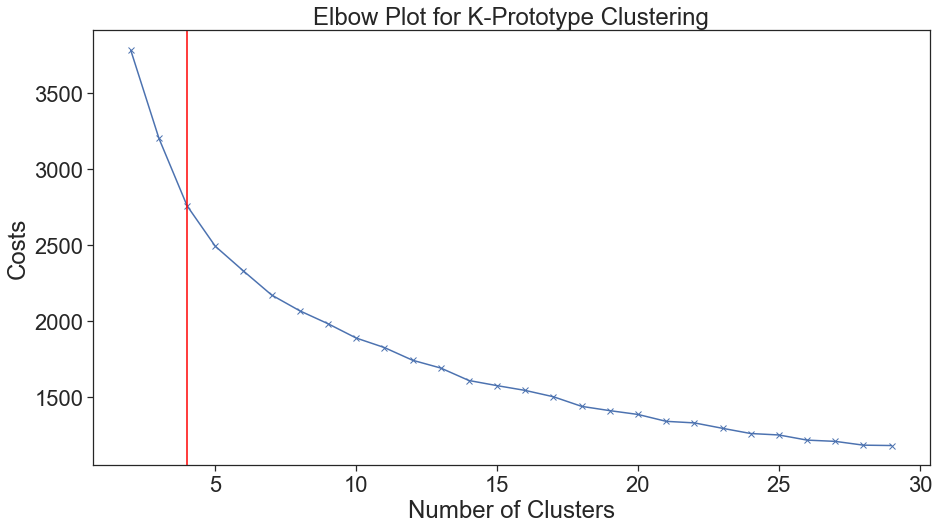

In [12]:
# Plotting the elbow plot again 
plt.figure(figsize= (15,8))
plt.plot(n_clusters, costs, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Costs')
plt.title('Elbow Plot for K-Prototype Clustering')
plt.axvline(x=4, color='red')
plt.show()

In [13]:
kprot_data.head()

age    income urban_rural_class   no_cars  CO2_cruise  CO2_flight  \
0  1.698314  0.107831           zentral  0.204851   -0.349480    1.148820   
1  1.472446 -1.449330      sehr zentral  1.228155    2.864273    1.302127   
2  1.510853 -0.753910          peripher -1.290552   -0.349480   -0.128851   
3  1.985096 -0.226188      sehr zentral  0.204851   -0.349480    1.115121   
4  0.792913 -0.226188      sehr zentral -1.290552   -0.349480   -1.054372   

   CO2_public_transport  CO2_car_total  belief_diff_mobility  
0             -1.614733       0.253905             -0.158674  
1              0.619298       0.974817             -1.151139  
2              0.619298      -1.106692              0.693456  
3             -1.614733       0.253905             -0.757650  
4              0.619298      -1.106692              0.254507

In [14]:
categorical_columns = [2] #make sure to specify correct indices

In [15]:
## Running k-prototype

np.random.seed(123)

kproto = KPrototypes(n_clusters= 4, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

In [16]:
pd.Series(clusters).value_counts()

2    203
1    176
3    145
0     64
dtype: int64

In [17]:
#Percentages for each cluster

round(100*pd.Series(clusters).value_counts()/len(clusters),2)

2    34.52
1    29.93
3    24.66
0    10.88
dtype: float64

In [18]:
# Cluster Centroids
print(kproto.cluster_centroids_)

[['-0.09824047410892645' '0.18343840284268573' '0.2797064966567219'
  '2.8613654458304603' '0.7547354415956465' '0.13060338692779627'
  '0.3299184655113894' '-0.8013854359071523' 'sehr zentral']
 ['-0.20715424404732732' '0.35541209834096965' '0.5601258030159265'
  '-0.3494797491090647' '0.11644517634663637' '0.6192975147412629'
  '0.5350287977233228' '-0.2283482925997057' 'sehr zentral']
 ['-0.15086085674067082' '-0.49551670963769184' '-1.0521084630889939'
  '-0.34947974910906465' '-0.1084988021445697' '0.5752772132914924'
  '-1.0513184886109046' '0.3537663729592048' 'sehr zentral']
 ['0.5060089049217761' '0.18136072390695743' '0.669618350967122'
  '-0.3494797491090649' '-0.3225666376812573' '-1.6147327838345926'
  '0.6768124344550366' '0.13560961161991397' 'zentral']]


In [19]:
## Placeholder: within cluster sum of squares

In [20]:
## Placeholder: distances between cluster centroids

In [21]:
df2['cluster_id'] = clusters

In [22]:
df2_nonscale = df[['age','income', 'RLK2022', 'no_cars',
          'CO2_cruise', 'CO2_flight', 'CO2_public_transport','CO2_car_total', 'CO2_mobility','belief_diff_mobility']]

In [23]:
df2_nonscale['cluster_id'] = clusters

C:\Users\leajo\AppData\Local\Temp\ipykernel_20380\2454060158.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



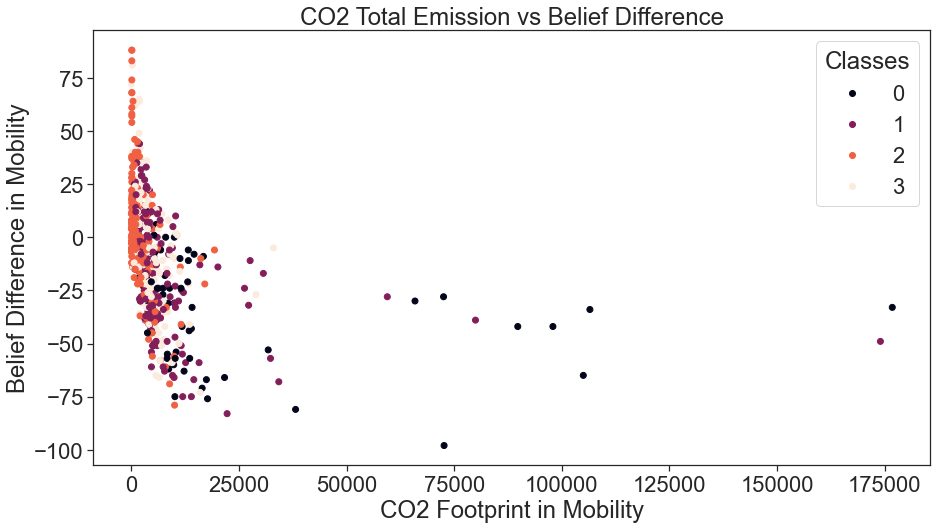

In [24]:
# Scatterplot: CO2 Total Emission vs Belief difference 

sns.set_style("ticks")

x = df2_nonscale['CO2_mobility']
y = df2_nonscale['belief_diff_mobility']

fig, ax = plt.subplots(figsize = (15, 8))

scatter = ax.scatter(x, y, c=df2_nonscale['cluster_id'])
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")


plt.title('CO2 Total Emission vs Belief Difference')
plt.xlabel('CO2 Footprint in Mobility')
plt.ylabel('Belief Difference in Mobility')

plt.show()

In [25]:
df2_nonscale.groupby(['cluster_id']).mean().round(2)

age   income  no_cars  CO2_cruise  CO2_flight  \
cluster_id                                                    
0           33.62  3493.75     1.17     9705.19     5511.72   
1           33.10  3820.98     1.37        0.00     2965.06   
2           32.98  2294.13     0.16        0.00     1674.79   
3           42.17  3469.17     1.47        0.00     1296.59   

            CO2_public_transport  CO2_car_total  CO2_mobility  \
cluster_id                                                      
0                          84.22        5392.00      20693.12   
1                         107.80        4319.52       7392.38   
2                         105.68          53.55       1834.01   
3                           0.00        3501.75       4798.34   

            belief_diff_mobility  
cluster_id                        
0                         -31.86  
1                         -15.56  
2                           1.36  
3                          -4.94

In [26]:
df2_nonscale.mean().round(2)

C:\Users\leajo\AppData\Local\Temp\ipykernel_20380\3835566406.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



age                       35.35
income                  3171.48
no_cars                    0.96
CO2_cruise              1056.35
CO2_flight              2385.35
CO2_public_transport      77.92
CO2_car_total           2761.82
CO2_mobility            6281.43
belief_diff_mobility      -8.87
cluster_id                 1.73
dtype: float64

In [27]:
df2_nonscale.groupby(['cluster_id'])['RLK2022'].agg(pd.Series.mode)

cluster_id
0    sehr zentral
1    sehr zentral
2    sehr zentral
3         zentral
Name: RLK2022, dtype: object

In [28]:
df2_nonscale['RLK2022'].agg(pd.Series.mode)

0    sehr zentral
Name: RLK2022, dtype: object

In [29]:
df2_nonscale.to_csv('cluster_results.csv')

## Plotting Clusters on UMAP plot

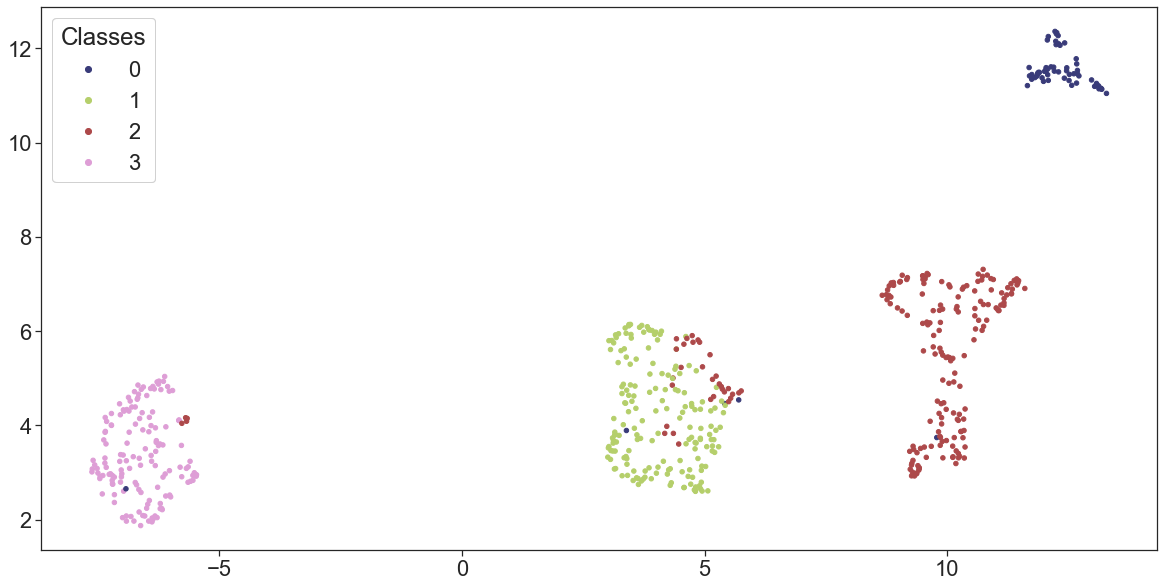

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[0][:, 0], embedding[0][:, 1], s=20, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=3),loc="upper left", title="Classes")
ax.add_artist(legend1)

## Evaluation of the model 

In [31]:
#Setting the objects to category 
lgbm_data = kprot_data.copy()
proto_clusters = pd.Series(clusters) 

for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')


In [32]:
#Kprototype clusters
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, proto_clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 245, in _count_physical_cores
    raise ValueError(


[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 470, number of used features: 9
[LightGBM] [Info] Start training from score -2.220907
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Info] Start training from score -1.065136
[LightGBM] [Info] Start training from score -1.399143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 470, number of used features: 9
[LightGBM] [Info] Start training from score -2.220907
[LightGBM] [Info] Start training from score -1.203973
[LightGBM] [Info] Start training from score -1.065136
[LightGBM] [Info] Start training from score -1.399143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of data points in the train set: 471, number of used features: 9
[LightGBM] [Info] Start training from score -2.223032
[LightGBM] [Info] Start training from score -1.206098
[LightGBM] [Info] Start training from score -1.061108
[LightGBM] [Info] Start training from score -1.401268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 471, number of used features: 9
[LightGBM] [Info] Start training from score -2.203614
[LightGBM] [Info] Start training from score -1.206098
[LightGBM] [Info] Start training from score -1.067262
[LightGBM] [Info] Start training from score -1.401268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [33]:
# Fit the model 
clf_kp.fit(lgbm_data, proto_clusters)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 588, number of used features: 9
[LightGBM] [Info] Start training from score -2.217844
[LightGBM] [Info] Start training from score -1.206243
[LightGBM] [Info] Start training from score -1.063521
[LightGBM] [Info] Start training from score -1.399993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(colsample_by_tree=0.8)

In [34]:
# SHAP values
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

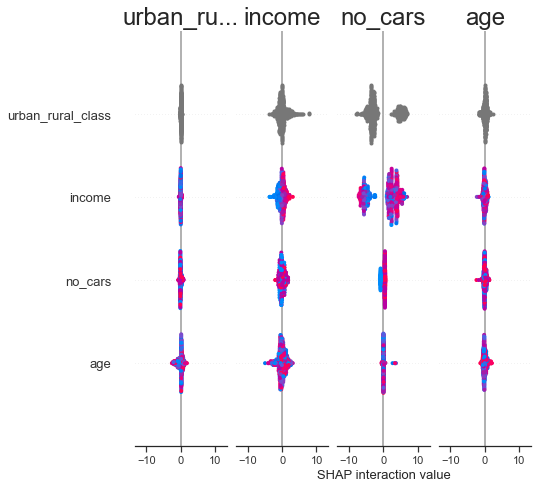

In [35]:
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

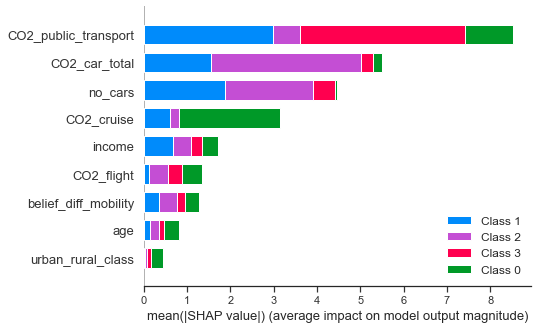

In [36]:
# https://github.com/shap/shap/issues/1906

shap.summary_plot(
    [shap_values_kp[:, :, class_ind] for class_ind in range(shap_values_kp.shape[-1])],
    feature_names=lgbm_data.columns,
    plot_type="bar"
)

## Analyzing the clustering results

- **variables used:** 'age','income', 'political_party','education', 'RLK2022', 'no_cars','CO2_cruise', 'CO2_flight', 'CO2_public_transport','CO2_car_total', 'CO2_mobility','belief_diff_mobility'

In [37]:
### Change column name: 'RLK2022' will be named as urban_rural_class as it is the variable used for modeling

df2_nonscale = df2_nonscale.rename(columns={'RLK2022':'urban_rural_class'})

In [128]:
### or if you want to start from here, load the csv file

df2_nonscale = pd.read_csv('cluster_results.csv', header = 0)
df2_nonscale = df2_nonscale.rename(columns={'RLK2022':'urban_rural_class'})

pd.set_option('display.max_columns', None)
df2_nonscale.head(9)


Unnamed: 0  age  income urban_rural_class  no_cars  CO2_cruise  CO2_flight  \
0           0   65  3000.0           zentral      1.0         0.0      2440.0   
1           1   59   800.0      sehr zentral      2.0      2710.0      5985.0   
2           2   60  1750.0          peripher      0.0         0.0       598.5   
3           3   73  2500.0      sehr zentral      1.0         0.0      2287.6   
4           4   43  2500.0      sehr zentral      0.0         0.0         0.0   
5           5   49  2300.0           zentral      1.0         0.0       532.0   
6           6   57   600.0           zentral      1.0         0.0         0.0   
7           7   39  5000.0      sehr zentral      2.0      4878.0      2074.8   
8           8   62     0.0      sehr zentral      2.0         0.0         0.0   

   CO2_public_transport  CO2_car_total  CO2_mobility  belief_diff_mobility  \
0                   0.0      1432.7280     3872.7280                 -14.0   
1                 107.8      2981.7315    11784.5315                 -42.0   
2                 107.8         0.0000      706.3000                  11.0   
3                   0.0      1432.7280     3720.3280                 -31.0   
4                 107.8         0.0000      107.8000                  -2.0   
5                 107.8      3581.8200     4221.6200                  22.0   
6                   0.0         0.0000        0.0000                  72.0   
7                 107.8     10371.2400    17431.8400                 -67.0   
8                 107.8      5008.5270     5116.3270                 -34.0   

   cluster_id  
0           3  
1           0  
2           2  
3           3  
4           2  
5           1  
6           3  
7           0  
8           1

In [129]:
# Setting the graph style
sns.set(font_scale = 2)
sns.set_style("ticks")

In [130]:
df2_nonscale.head()

Unnamed: 0  age  income urban_rural_class  no_cars  CO2_cruise  CO2_flight  \
0           0   65  3000.0           zentral      1.0         0.0      2440.0   
1           1   59   800.0      sehr zentral      2.0      2710.0      5985.0   
2           2   60  1750.0          peripher      0.0         0.0       598.5   
3           3   73  2500.0      sehr zentral      1.0         0.0      2287.6   
4           4   43  2500.0      sehr zentral      0.0         0.0         0.0   

   CO2_public_transport  CO2_car_total  CO2_mobility  belief_diff_mobility  \
0                   0.0      1432.7280     3872.7280                 -14.0   
1                 107.8      2981.7315    11784.5315                 -42.0   
2                 107.8         0.0000      706.3000                  11.0   
3                   0.0      1432.7280     3720.3280                 -31.0   
4                 107.8         0.0000      107.8000                  -2.0   

   cluster_id  
0           3  
1           0  
2           2  
3           3  
4           2

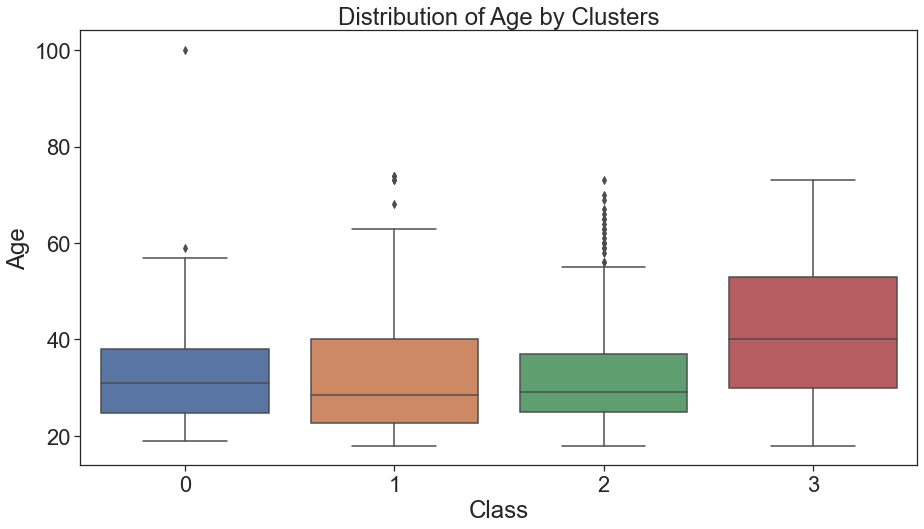

In [131]:
sns.set_style("ticks")

x_order = [0, 1, 2, 3]


fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

lines  = sns.boxplot(x=df2_nonscale['cluster_id'], y=df2_nonscale['age'], order = x_order).set(xlabel = 'Class', ylabel = 'Age')
plt.title('Distribution of Age by Clusters')

plt.show()

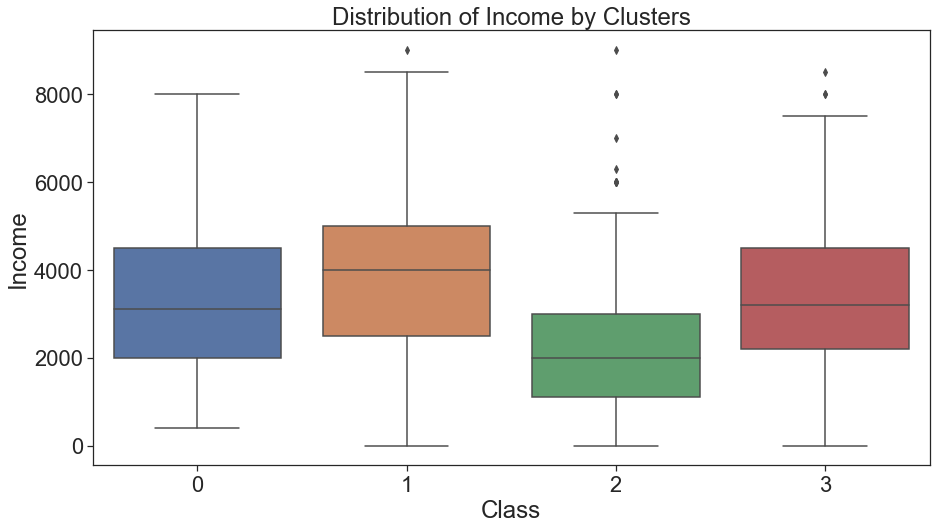

In [132]:
sns.set_style("ticks")

x_order = [0, 1, 2, 3]


fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)

lines  = sns.boxplot(x=df2_nonscale['cluster_id'], y=df2_nonscale['income'], order = x_order).set(xlabel = 'Class', ylabel = 'Income')
plt.title('Distribution of Income by Clusters')

plt.show()

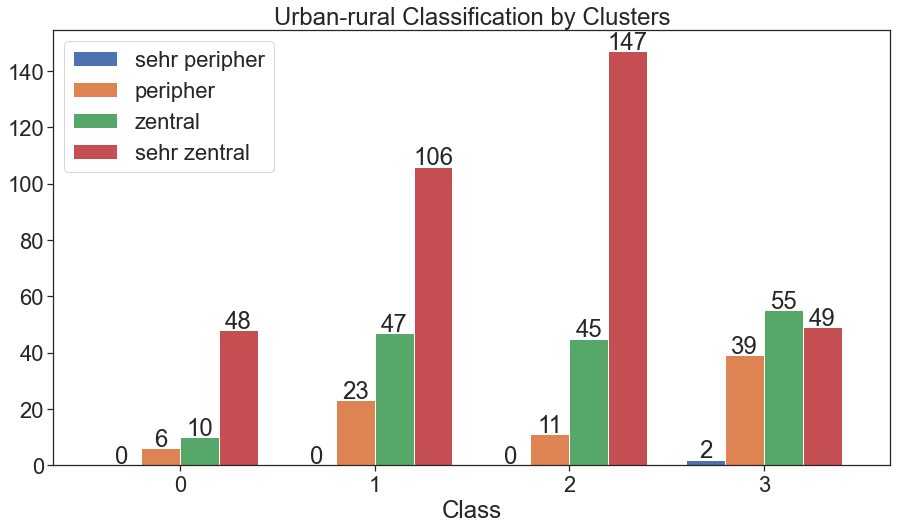

In [133]:
sns.set_style("ticks")

ax2 = df2_nonscale.groupby(['cluster_id', 'urban_rural_class']).size().unstack(level=1)[['sehr peripher', 'peripher', 'zentral', 'sehr zentral']].plot(kind='bar', figsize=(15,8), width = 0.8, title ='Urban-rural Classification by Clusters', xlabel = 'Class')
ax2.legend(loc='upper left')
ax2.tick_params(axis='x', rotation=0)

for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+ 3),
                ha='center',
                va='center')

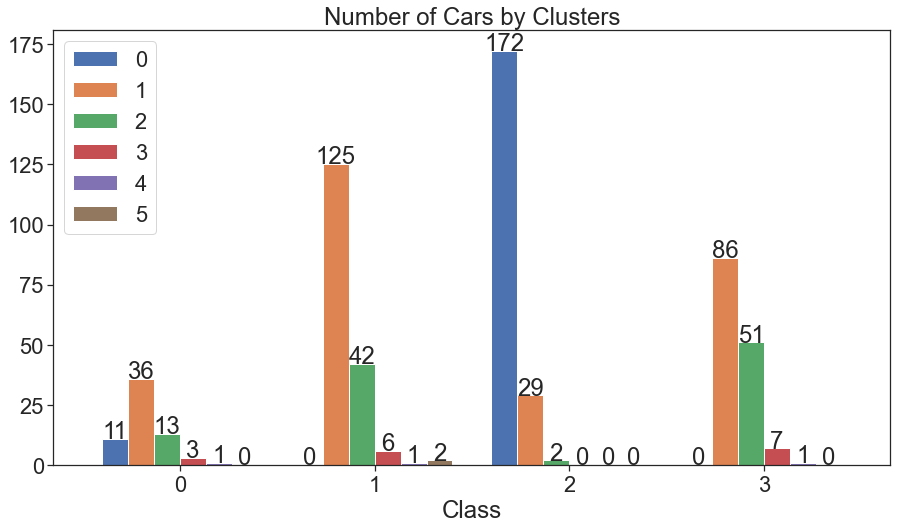

In [134]:
sns.set_style("ticks")


df2_nonscale['no_cars'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'no_cars']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='Number of Cars by Clusters',  xlabel = 'Class')
ax2.legend(loc='upper left')
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+ 3),
                ha='center',
                va='center')

In [135]:
round(172/(172+29+2),2)

0.85

In [136]:
def dist_continuous(variable):
    sns.set_style("ticks")

    x = df2_nonscale['cluster_id']
    y = df2_nonscale[variable]
    
    name_var_list = variable.split("_")
    name_var_list_new = []
    for i in name_var_list:
        if i != 'CO2':
            name_var_list_new.append(i.capitalize())
        else: name_var_list_new.append(i)
    
    name_var = ' '.join(map(str, name_var_list_new))        

    x_order = [0, 1, 2, 3]
   
    
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    
    sns.set(font_scale = 2)

    lines  = sns.boxplot(x=df2_nonscale['cluster_id'], y=df2_nonscale[variable], order = x_order).set(xlabel = 'Class', ylabel = name_var)

    plt.title('Distribution of ' + name_var +' by Clusters')
    plt.show()


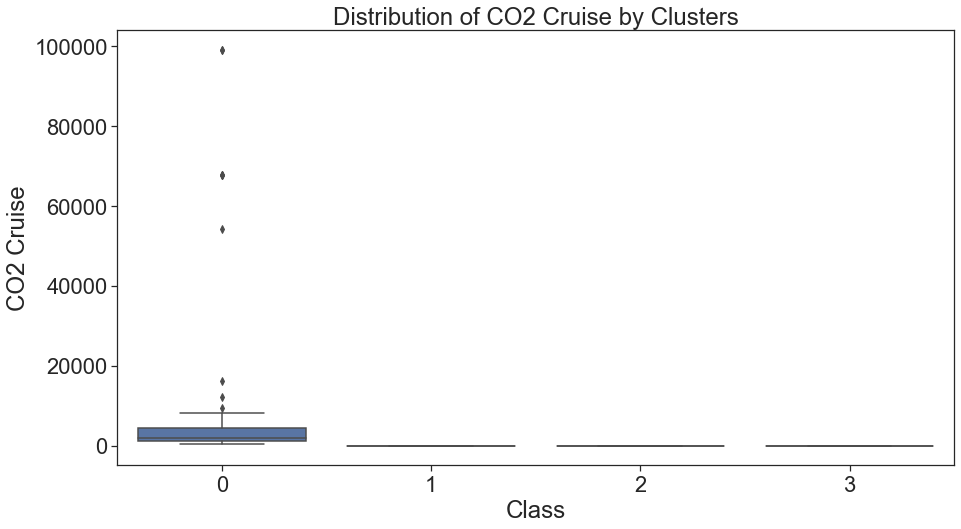

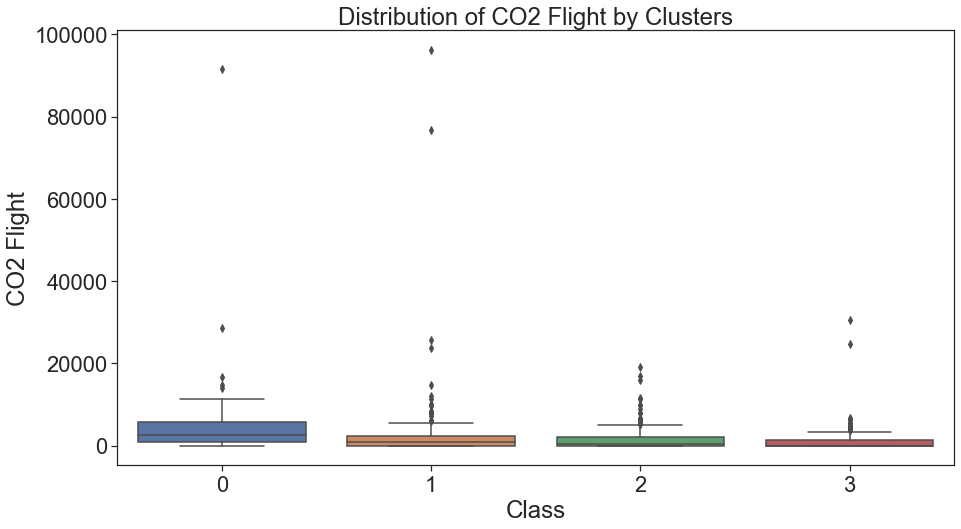

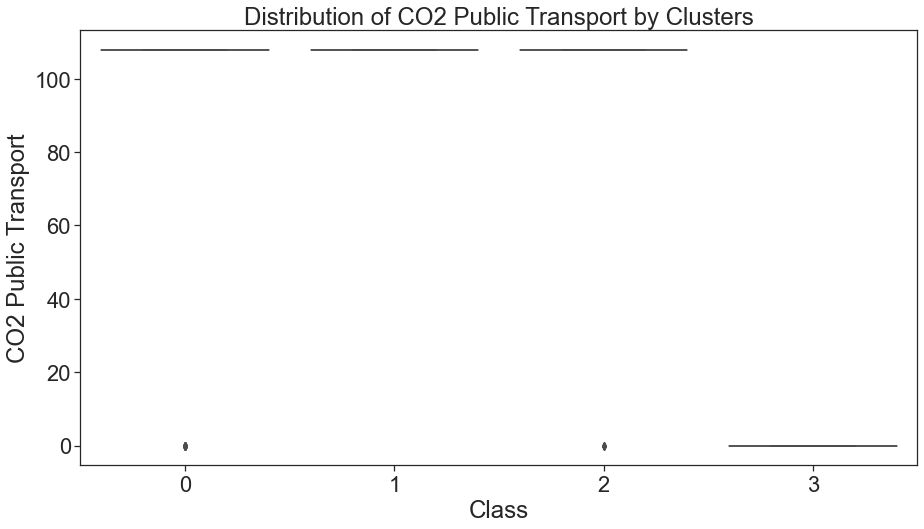

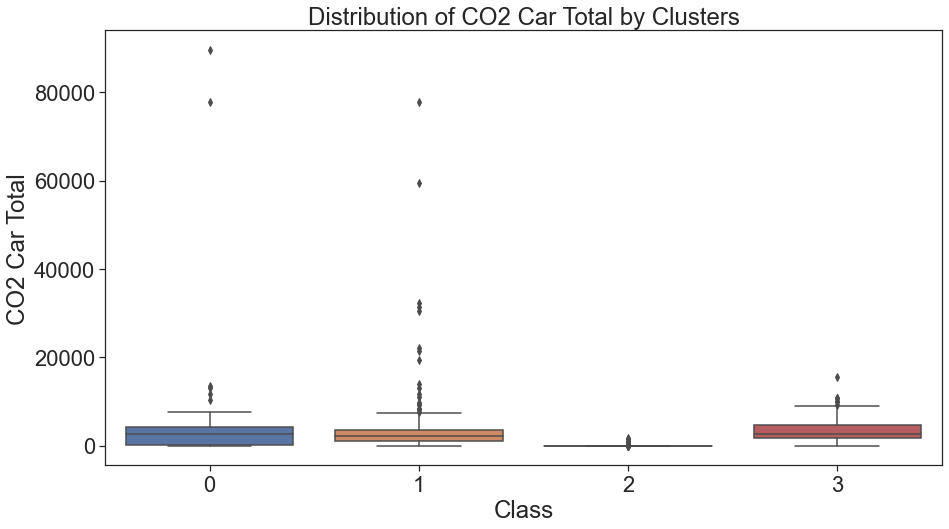

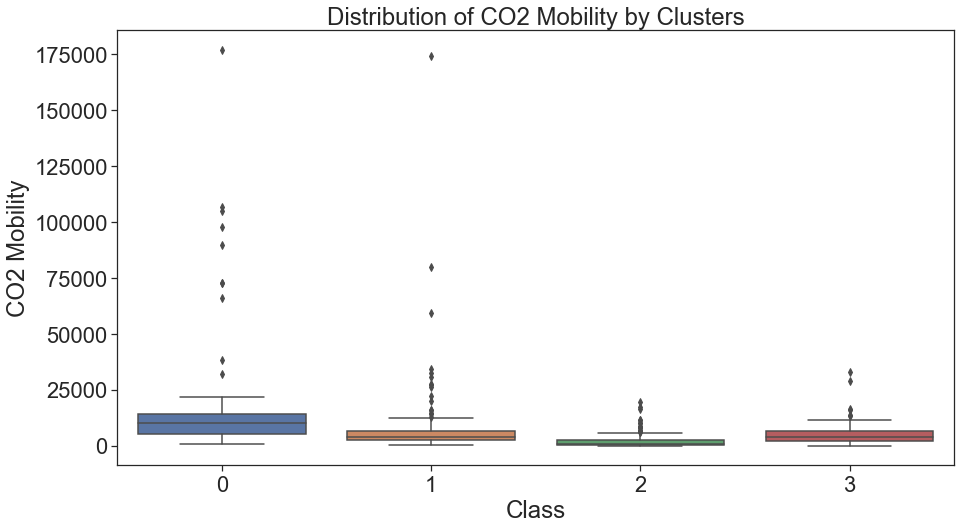

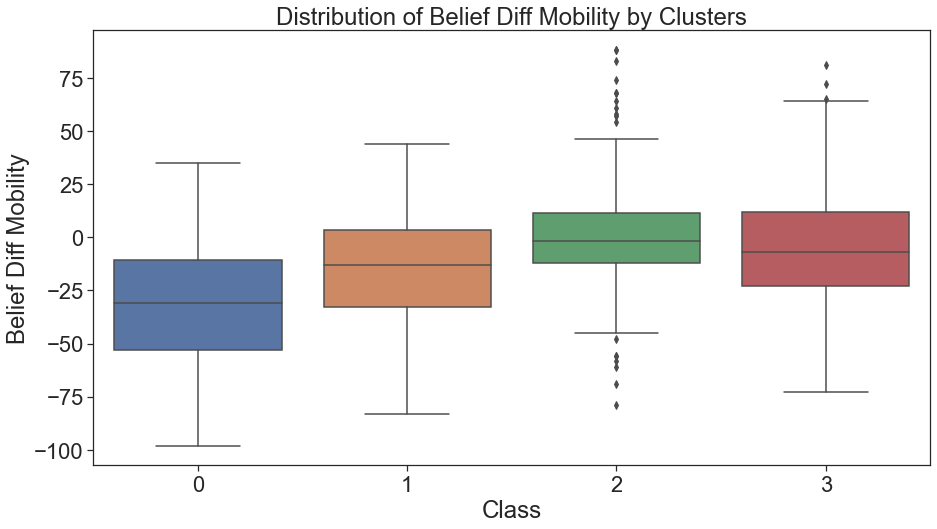

In [137]:
variables_list = ['CO2_cruise', 'CO2_flight', 'CO2_public_transport',
       'CO2_car_total', 'CO2_mobility', 'belief_diff_mobility']

for variable in variables_list: 
    dist_continuous(variable)

### Extra analysis to compare the clusters

In [138]:
# Creating a column for underestimation flag - 1: if underestimagte
df2_nonscale['underestimates'] = np.where(df2_nonscale['belief_diff_mobility'] < 0, 1, 0)

In [139]:
# percentage of the people who are underestimating

round(100*df2_nonscale.groupby(['cluster_id'])['underestimates'].sum()/df2_nonscale.groupby(['cluster_id'])['underestimates'].size(), 0)

cluster_id
0    89.0
1    70.0
2    53.0
3    61.0
Name: underestimates, dtype: float64

In [140]:
df2_nonscale.columns

Index(['Unnamed: 0', 'age', 'income', 'urban_rural_class', 'no_cars',
       'CO2_cruise', 'CO2_flight', 'CO2_public_transport', 'CO2_car_total',
       'CO2_mobility', 'belief_diff_mobility', 'cluster_id', 'underestimates'],
      dtype='object')

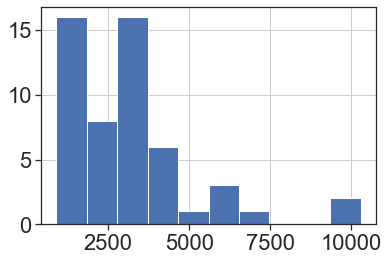

In [141]:
sns.set_style("ticks")

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1) & (df2_nonscale['underestimates'] == 0)]
df2_mob['CO2_mobility'].hist();

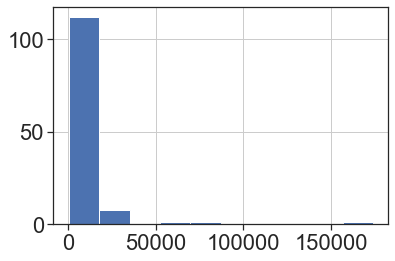

In [142]:
df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1) & (df2_nonscale['underestimates'] == 1)]

df2_mob['CO2_mobility'].hist();

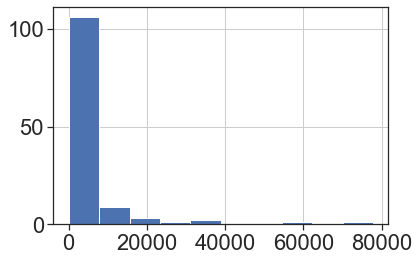

In [143]:
df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1) & (df2_nonscale['underestimates'] == 1)]

df2_mob['CO2_car_total'].hist();

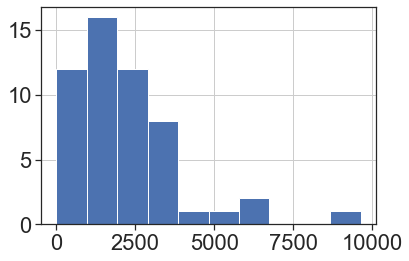

In [144]:
df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1) & (df2_nonscale['underestimates'] == 0)]

df2_mob['CO2_car_total'].hist();

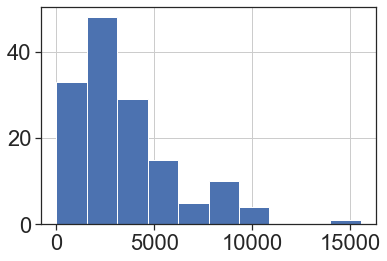

In [145]:
df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 3)]

df2_mob['CO2_car_total'].hist();

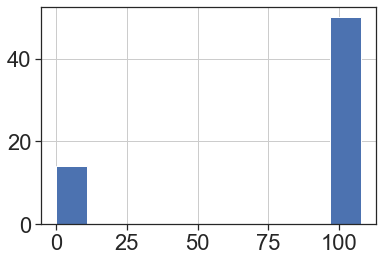

In [146]:
## Public transportation patterns in Class 0 

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 0)]

df2_mob['CO2_public_transport'].hist();

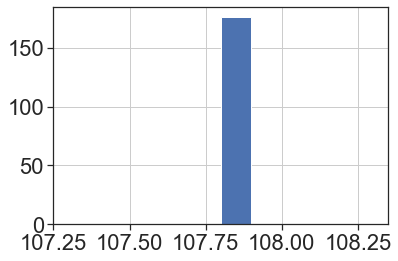

In [147]:
## Public transportation patterns in Class 1

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1)]

df2_mob['CO2_public_transport'].hist();

In [148]:
# percentage of people not using public transporation in Class 0
len(df2_nonscale[(df2_nonscale['cluster_id'] == 0) & (df2_nonscale['CO2_public_transport'] == 0)]) / len(df2_nonscale[(df2_nonscale['cluster_id'] == 0)])

0.21875

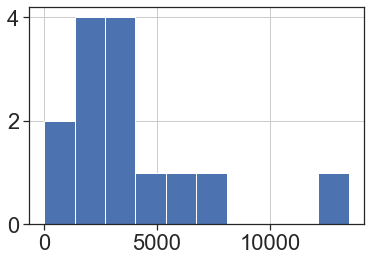

In [149]:
## Driving patterns of people not using public transporation in Class 0 

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 0) & (df2_nonscale['CO2_public_transport'] == 0)]

df2_mob['CO2_car_total'].hist();

<AxesSubplot:xlabel='urban_rural_class'>

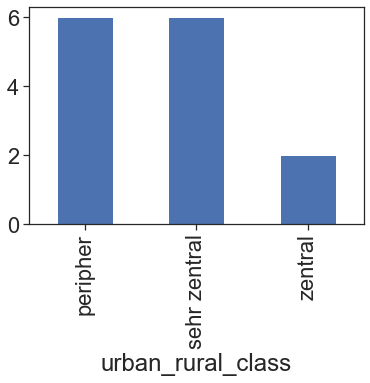

In [150]:
## Urban-rural area of people not using public transporation in Class 0 

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 0) & (df2_nonscale['CO2_public_transport'] == 0)]


df2_mob.groupby(['urban_rural_class'])['urban_rural_class'].count().plot(kind='bar')

<AxesSubplot:xlabel='urban_rural_class'>

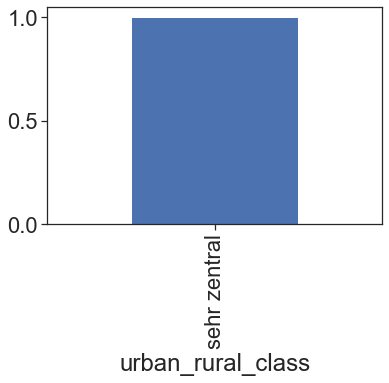

In [151]:
## Urban-rural area of people not using public transporation nor car in Class 0 

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 0) & (df2_nonscale['CO2_public_transport'] == 0) & (df2_nonscale['CO2_car_total'] == 0)]


df2_mob.groupby(['urban_rural_class'])['urban_rural_class'].count().plot(kind='bar')

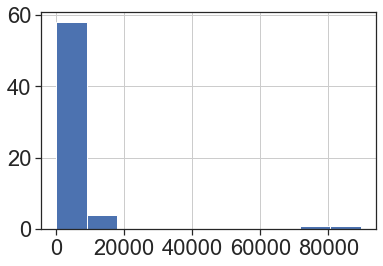

In [152]:
## Driving patterns in Class 0 

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 0)]

df2_mob['CO2_car_total'].hist();

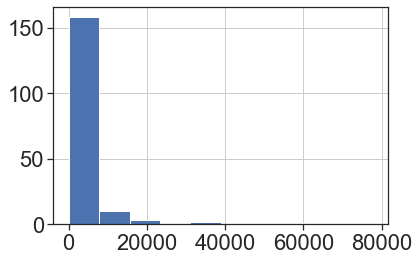

In [153]:
## Driving patterns in Class 1

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1)]

df2_mob['CO2_car_total'].hist();

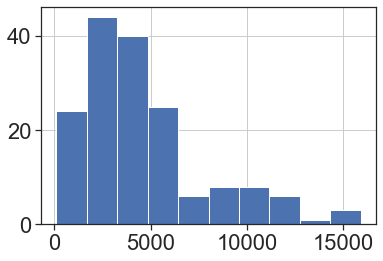

In [154]:
## investigating the outliers in Class 1

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1) & (df2_nonscale['CO2_mobility'] < 20000)]

df2_mob['CO2_mobility'].hist();

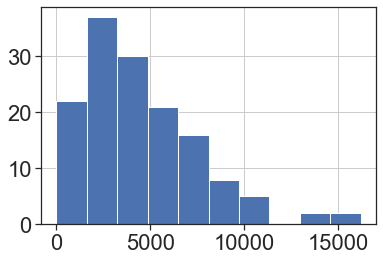

In [155]:
## investigating the outliers in Class 3

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 3) & (df2_nonscale['CO2_mobility'] < 20000) ]

df2_mob['CO2_mobility'].hist();

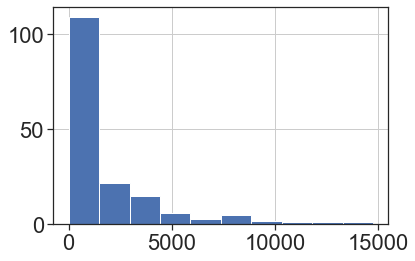

In [156]:
## investigating the outliers in Class 1

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1) & (df2_nonscale['CO2_mobility'] < 20000)]

df2_mob['CO2_flight'].hist();

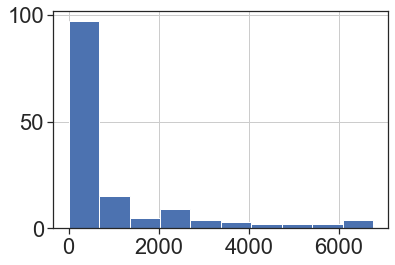

In [157]:
## investigating the outliers in Class 3

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 3) & (df2_nonscale['CO2_mobility'] < 20000) ]

df2_mob['CO2_flight'].hist();

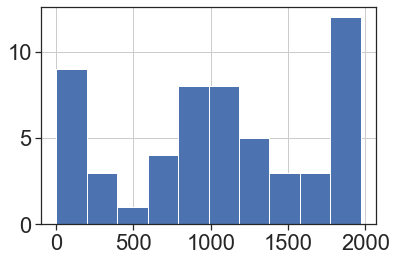

In [158]:
## investigating the outliers in Class 1

df2_mob = df2_nonscale[(df2_nonscale['cluster_id'] == 1) & (df2_nonscale['urban_rural_class']  == 'sehr zentral') & (df2_nonscale['CO2_car_total'] > 0) & (df2_nonscale['CO2_car_total'] < 2000)]

df2_mob['CO2_car_total'].hist();

In [159]:
### Comparing the engine

engine = pd.read_csv('data_cleaned_descriptive_analysis_final_batch_engine.csv', header = 0)
engine = engine.rename(columns={'RLK2022':'urban_rural_class'})

pd.set_option('display.max_columns', None)
engine.head(9)


Unnamed: 0  no_cars    gender  age  income       political_party  \
0          25      1.0  Weiblich   65  3000.0               CDU/CSU   
1          26      2.0  Weiblich   59   800.0          Keine Angabe   
2          27      0.0  Weiblich   60  1750.0          Keine Angabe   
3          28      1.0  Männlich   73  2500.0                   SPD   
4          30      0.0  Männlich   43  2500.0  Einer anderen Partei   
5          31      1.0  Weiblich   49  2300.0               CDU/CSU   
6          32      1.0  Weiblich   57   600.0               CDU/CSU   
7          33      2.0  Männlich   39  5000.0                   SPD   
8          34      2.0  Männlich   62     0.0          Keine Angabe   

                                           education  postal_code EUROSTAT  \
0  (Fach-) Hochschulabschluss (Bachelor, Master, ...        66440       PU   
1  Allgemeine oder fachgebundene Hochschulreife/A...        65933       PU   
2  Berufsausbildung, Lehre oder Ausbildung an ein...        95028       IN   
3  Realschulabschluss (Mittlere Reife) oder gleic...        63741       IN   
4  Berufsausbildung, Lehre oder Ausbildung an ein...        13059       PU   
5  Berufsausbildung, Lehre oder Ausbildung an ein...        39112       IN   
6  Realschulabschluss (Mittlere Reife) oder gleic...        78244       IN   
7  (Fach-) Hochschulabschluss (Bachelor, Master, ...        10115       PU   
8  (Fach-) Hochschulabschluss (Bachelor, Master, ...        46149       PU   

  urban_rural_class                                    KTU2022  \
0           zentral                          Städtischer Kreis   
1      sehr zentral                       kreisfreie Großstadt   
2          peripher  Ländlicher Kreis mit Verdichtungsansätzen   
3      sehr zentral                          Städtischer Kreis   
4      sehr zentral                       kreisfreie Großstadt   
5           zentral                       kreisfreie Großstadt   
6           zentral                          Städtischer Kreis   
7      sehr zentral                       kreisfreie Großstadt   
8      sehr zentral                       kreisfreie Großstadt   

         federal_state      NUTS2_NAME                           NUTS3_NAME  \
0             Saarland        Saarland                      Saarpfalz-Kreis   
1               Hessen       Darmstadt  Frankfurt am Main, Kreisfreie Stadt   
2               Bayern     Oberfranken                Hof, Kreisfreie Stadt   
3               Bayern    Unterfranken      Aschaffenburg, Kreisfreie Stadt   
4               Berlin          Berlin                               Berlin   
5       Sachsen-Anhalt  Sachsen-Anhalt          Magdeburg, Kreisfreie Stadt   
6    Baden-Württemberg        Freiburg                             Konstanz   
7               Berlin          Berlin                               Berlin   
8  Nordrhein-Westfalen      Düsseldorf         Oberhausen, Kreisfreie Stadt   

   CO2_housing  CO2_electricity  CO2_housing_electricity  CO2_cruise  \
0   5038.20000         1053.000               6091.20000         0.0   
1   1785.00000          487.500               2272.50000      2710.0   
2    200.10240          663.000                863.10240         0.0   
3    648.48000          975.000               1623.48000         0.0   
4   1923.48625          390.000               2313.48625         0.0   
5   2793.09600          663.000               3456.09600         0.0   
6   1620.00000          112.000               1732.00000         0.0   
7    902.67450           26.320                928.99450      4878.0   
8   2340.00000          825.825               3165.82500         0.0   

   CO2_flight  CO2_public_transport   CO2_car1  CO2_car2  CO2_car3  CO2_car4  \
0      2440.0                   0.0  1432.7280     0.000       0.0       0.0   
1      5985.0                 107.8  1944.6075  1037.124       0.0       0.0   
2       598.5                 107.8     0.0000     0.000       0.0       0.0   
3      2287.6     

In [37]:
len(engine)

588

In [160]:
df2_nonscale.head()

Unnamed: 0  age  income urban_rural_class no_cars  CO2_cruise  CO2_flight  \
0           0   65  3000.0           zentral       1         0.0      2440.0   
1           1   59   800.0      sehr zentral       2      2710.0      5985.0   
2           2   60  1750.0          peripher       0         0.0       598.5   
3           3   73  2500.0      sehr zentral       1         0.0      2287.6   
4           4   43  2500.0      sehr zentral       0         0.0         0.0   

   CO2_public_transport  CO2_car_total  CO2_mobility  belief_diff_mobility  \
0                   0.0      1432.7280     3872.7280                 -14.0   
1                 107.8      2981.7315    11784.5315                 -42.0   
2                 107.8         0.0000      706.3000                  11.0   
3                   0.0      1432.7280     3720.3280                 -31.0   
4                 107.8         0.0000      107.8000                  -2.0   

   cluster_id  underestimates  
0           3               1  
1           0               1  
2           2               0  
3           3               1  
4           2               1

In [161]:
engine.columns

Index(['Unnamed: 0', 'no_cars', 'gender', 'age', 'income', 'political_party',
       'education', 'postal_code', 'EUROSTAT', 'urban_rural_class', 'KTU2022',
       'federal_state', 'NUTS2_NAME', 'NUTS3_NAME', 'CO2_housing',
       'CO2_electricity', 'CO2_housing_electricity', 'CO2_cruise',
       'CO2_flight', 'CO2_public_transport', 'CO2_car1', 'CO2_car2',
       'CO2_car3', 'CO2_car4', 'CO2_car5', 'CO2_car_total', 'CO2_mobility',
       'CO2_food', 'CO2_other_consumption', 'public_emission', 'CO2_total',
       'belief_housing_electricity', 'belief_mobility', 'belief_food',
       'belief_other_consumption', 'belief_total', 'batch', 'engine_1',
       'engine_2', 'engine_3', 'engine_4', 'engine_5', 'engine_6', 'engine_7',
       'engine_8', 'engine_9', 'engine_10',
       'actual_rank_CO2_housing_electricity1', 'actual_rank_CO2_mobility1',
       'actual_rank_CO2_food1', 'actual_rank_CO2_other_consumption1',
       'actual_rank_CO2_total1', 'actual_rank_CO2_housing_electricity2',
   

In [162]:
## Adding the engine information 

df2_nonscale['engine_1'] = engine['engine_1']
df2_nonscale['engine_2'] = engine['engine_2']
df2_nonscale['engine_3'] = engine['engine_3']
df2_nonscale['engine_4'] = engine['engine_4']
df2_nonscale['engine_5'] = engine['engine_5']
df2_nonscale['engine_6'] = engine['engine_6']
df2_nonscale['engine_7'] = engine['engine_7']
df2_nonscale['engine_8'] = engine['engine_8']
df2_nonscale['engine_9'] = engine['engine_9']
df2_nonscale['engine_10'] = engine['engine_10']


df2_nonscale.head()

Unnamed: 0  age  income urban_rural_class no_cars  CO2_cruise  CO2_flight  \
0           0   65  3000.0           zentral       1         0.0      2440.0   
1           1   59   800.0      sehr zentral       2      2710.0      5985.0   
2           2   60  1750.0          peripher       0         0.0       598.5   
3           3   73  2500.0      sehr zentral       1         0.0      2287.6   
4           4   43  2500.0      sehr zentral       0         0.0         0.0   

   CO2_public_transport  CO2_car_total  CO2_mobility  belief_diff_mobility  \
0                   0.0      1432.7280     3872.7280                 -14.0   
1                 107.8      2981.7315    11784.5315                 -42.0   
2                 107.8         0.0000      706.3000                  11.0   
3                   0.0      1432.7280     3720.3280                 -31.0   
4                 107.8         0.0000      107.8000                  -2.0   

   cluster_id  underestimates engine_1 engine_2 engine_3 engine_4 engine_5  \
0           3               1   Benzin      NaN      NaN      NaN      NaN   
1           0               1   Benzin   Benzin   Benzin   Benzin      NaN   
2           2               0      NaN      NaN      NaN      NaN      NaN   
3           3               1   Benzin      NaN      NaN      NaN      NaN   
4           2               1      NaN      NaN      NaN      NaN      NaN   

  engine_6 engine_7  engine_8 engine_9  engine_10  
0      NaN      NaN       NaN      NaN        NaN  
1      NaN      NaN       NaN      NaN        NaN  
2      NaN      NaN       NaN      NaN        NaN  
3      NaN      NaN       NaN      NaN        NaN  
4      NaN      NaN       NaN      NaN        NaN

In [163]:
## All engines 

all_engine = engine['engine_1'].to_list() + engine['engine_3'].to_list() + engine['engine_5'].to_list() + engine['engine_7'].to_list() + engine['engine_9'].to_list()

len(all_engine)

2940

In [164]:
all_engine_clean = [x for x in all_engine if pd.notnull(x)]

len(all_engine_clean)

df_engine = pd.DataFrame({'col':all_engine_clean})


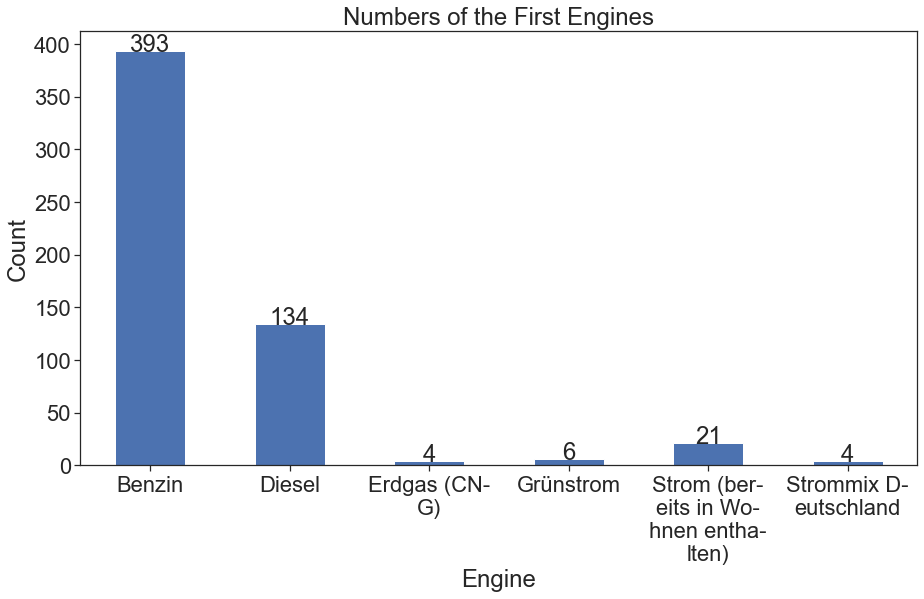

In [165]:
# Bar chart for the first engine 

sns.set_style("ticks")

count = df_engine.groupby(['col']).size().to_frame().reset_index()


ax = count.set_index('col').plot(kind='bar', figsize=(15, 8), ylabel='Count', xlabel = 'Engine', title = 'Numbers of the First Engines', rot = 360)
ax.get_legend().remove()

for p in ax.patches:
    ax.annotate(p.get_height(),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+6),
                ha='center',
                va='center')
max_chars = 10

new_labels = ['-\n'.join(label._text[i:i + max_chars] 
                        for i in range(0, len(label._text), max_chars ))
              for label in ax.get_xticklabels()]

ax.set_xticklabels(new_labels);

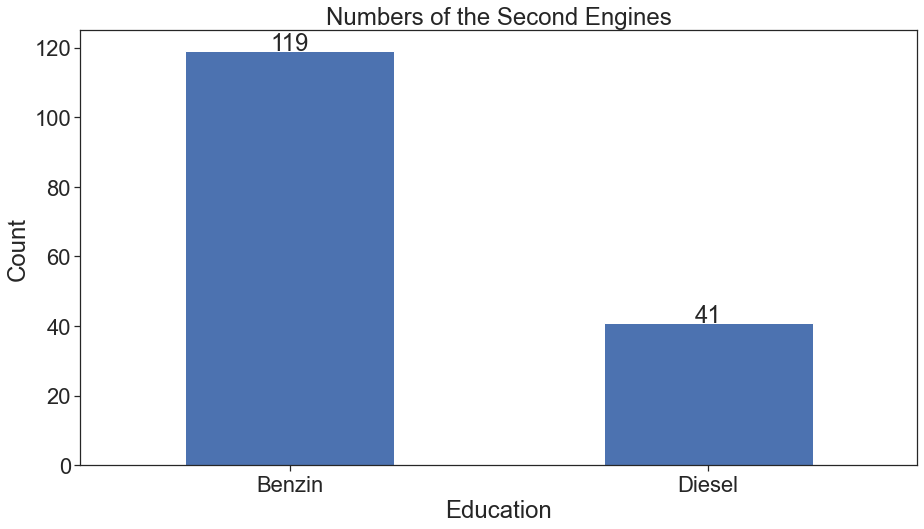

In [166]:
## bar chart for the second engine 

all_engine2 = engine['engine_2'].to_list() + engine['engine_4'].to_list() + engine['engine_6'].to_list() + engine['engine_8'].to_list() + engine['engine_10'].to_list()
all_engine_clean2 = [x for x in all_engine2 if pd.notnull(x)]

df_engine2 = pd.DataFrame({'col':all_engine_clean2})


count = df_engine2.groupby(['col']).size().to_frame().reset_index()


ax = count.set_index('col').plot(kind='bar', figsize=(15, 8), xlabel='Education', ylabel='Count',  title = 'Numbers of the Second Engines', rot = 360)
ax.get_legend().remove()

for p in ax.patches:
    ax.annotate(p.get_height(),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+2),
                ha='center',
                va='center')
max_chars = 10

new_labels = ['-\n'.join(label._text[i:i + max_chars] 
                        for i in range(0, len(label._text), max_chars ))
              for label in ax.get_xticklabels()]

ax.set_xticklabels(new_labels);

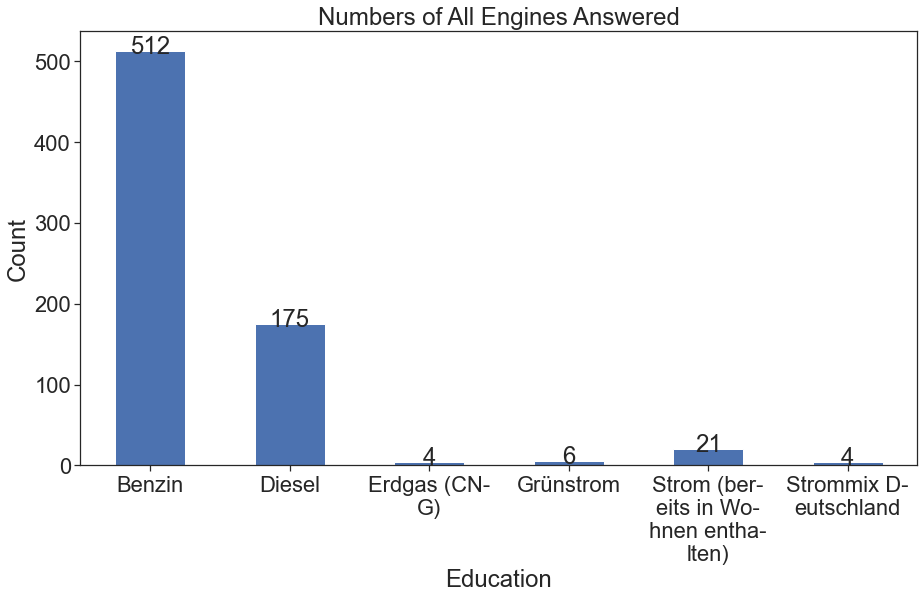

In [171]:
## All engine answered 

df_engine3 = pd.concat([df_engine, df_engine2])


count = df_engine3.groupby(['col']).size().to_frame().reset_index()


ax = count.set_index('col').plot(kind='bar', figsize=(15, 8), xlabel='Education', ylabel='Count',  title = 'Numbers of All Engines Answered', rot = 360)
ax.get_legend().remove()

for p in ax.patches:
    ax.annotate(p.get_height(),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+5),
                ha='center',
                va='center')
max_chars = 10

new_labels = ['-\n'.join(label._text[i:i + max_chars] 
                        for i in range(0, len(label._text), max_chars ))
              for label in ax.get_xticklabels()]

ax.set_xticklabels(new_labels);

In [173]:
round(100*df_engine3.groupby(['col']).size()/len(df_engine3['col']), 2)

col
Benzin                                 70.91
Diesel                                 24.24
Erdgas (CNG)                            0.55
Grünstrom                               0.83
Strom (bereits in Wohnen enthalten)     2.91
Strommix Deutschland                    0.55
dtype: float64

In [174]:
0.83+2.91+0.55

4.29

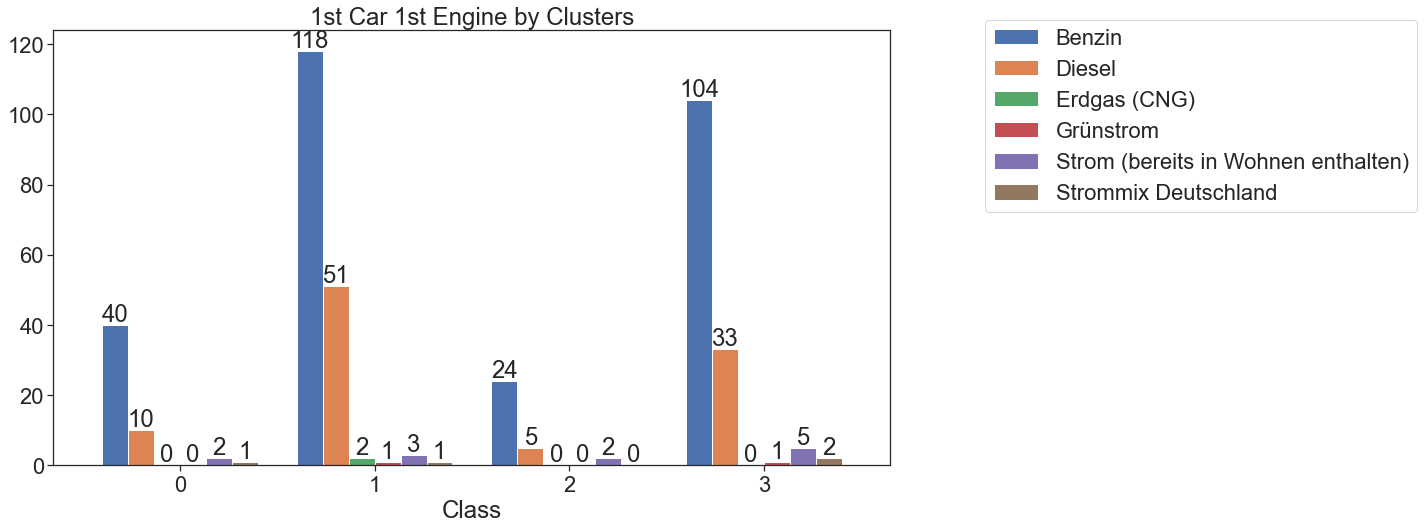

In [48]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_1']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='1st Car 1st Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+ 3),
                ha='center',
                va='center')

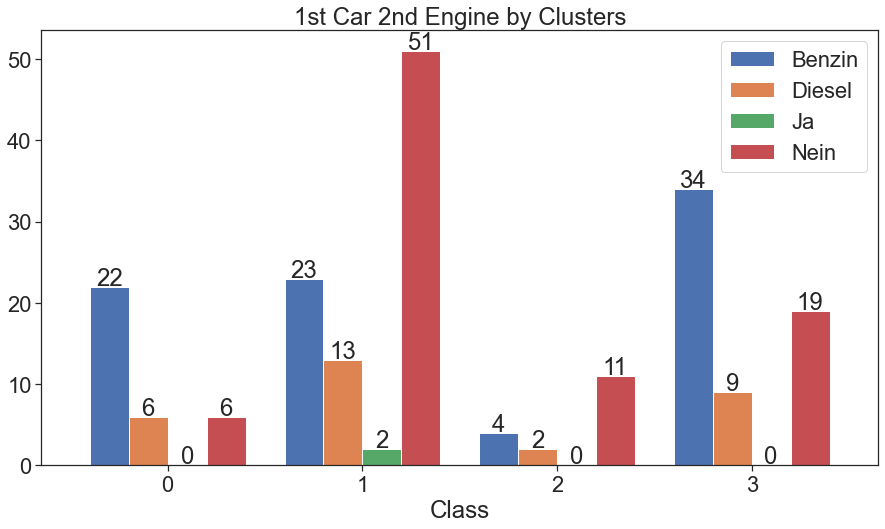

In [73]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_2']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='1st Car 2nd Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1, 1))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+1),
                ha='center',
                va='center')

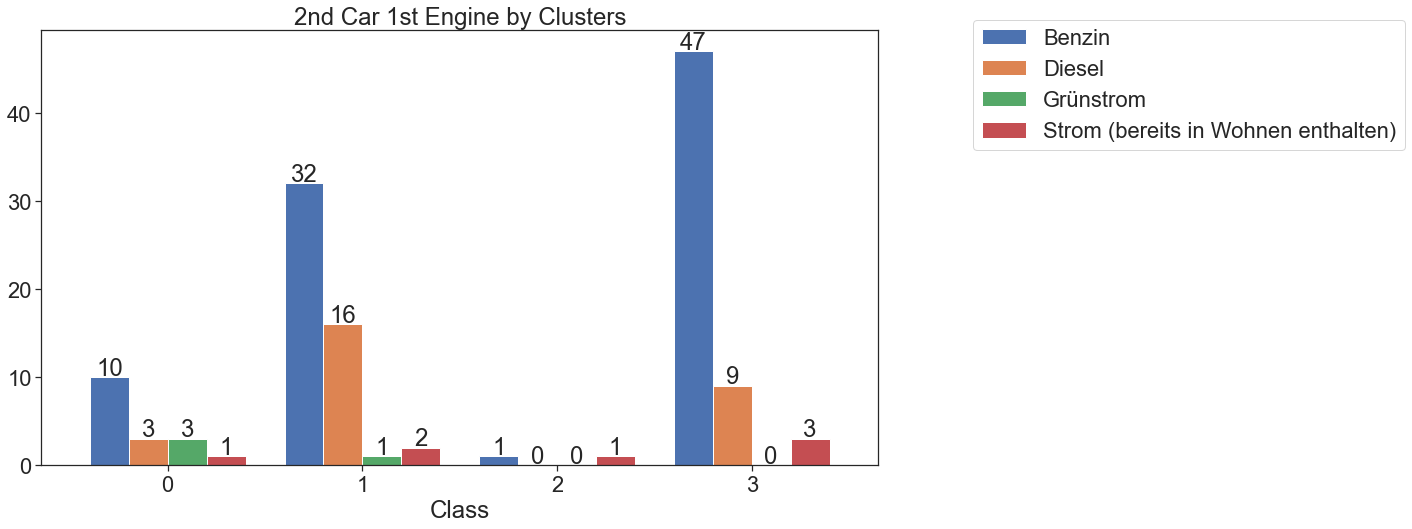

In [50]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_3']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='2nd Car 1st Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+ 1),
                ha='center',
                va='center')

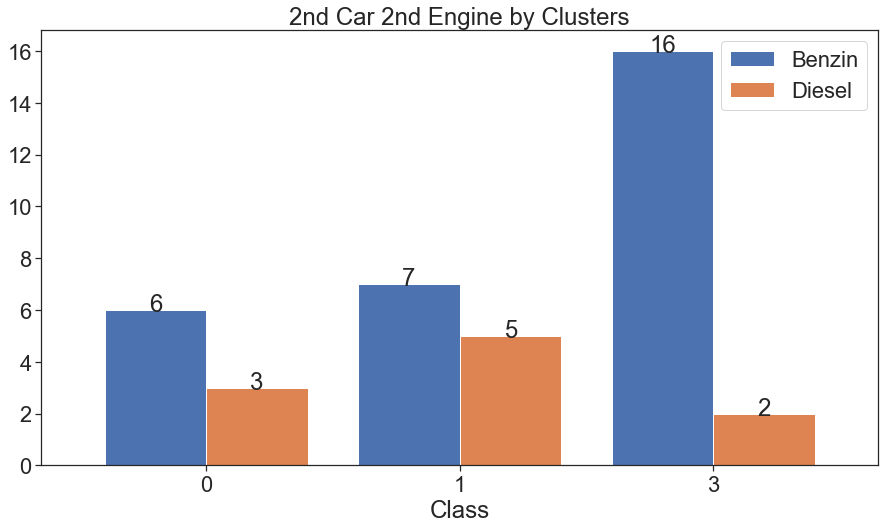

In [77]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_4']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='2nd Car 2nd Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1,1))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+ 0.2),
                ha='center',
                va='center')

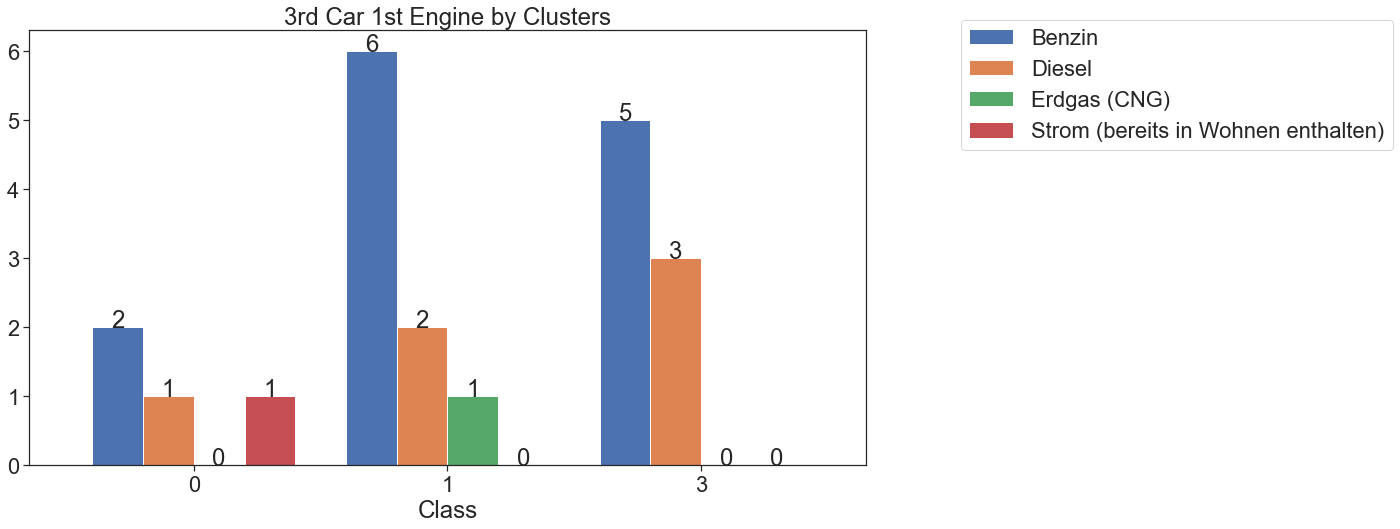

In [58]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_5']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='3rd Car 1st Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+0.1),
                ha='center',
                va='center')

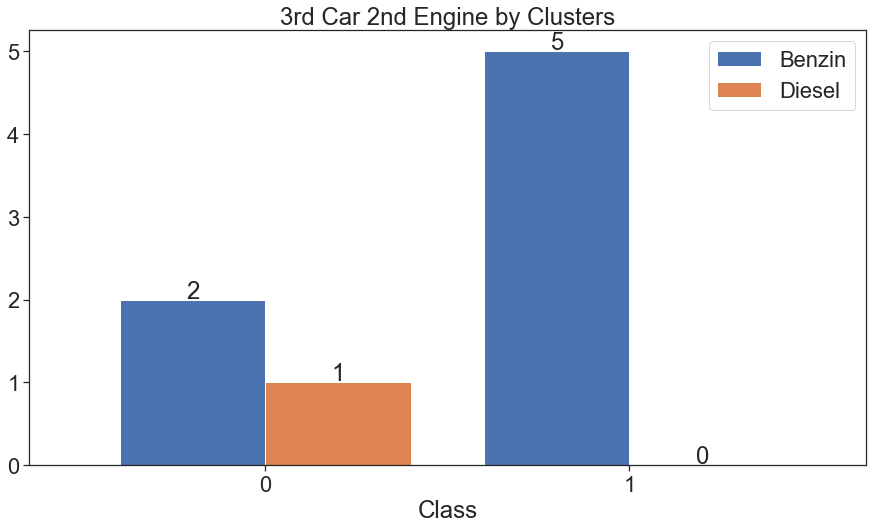

In [78]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_6']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='3rd Car 2nd Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1,1))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+0.1),
                ha='center',
                va='center')

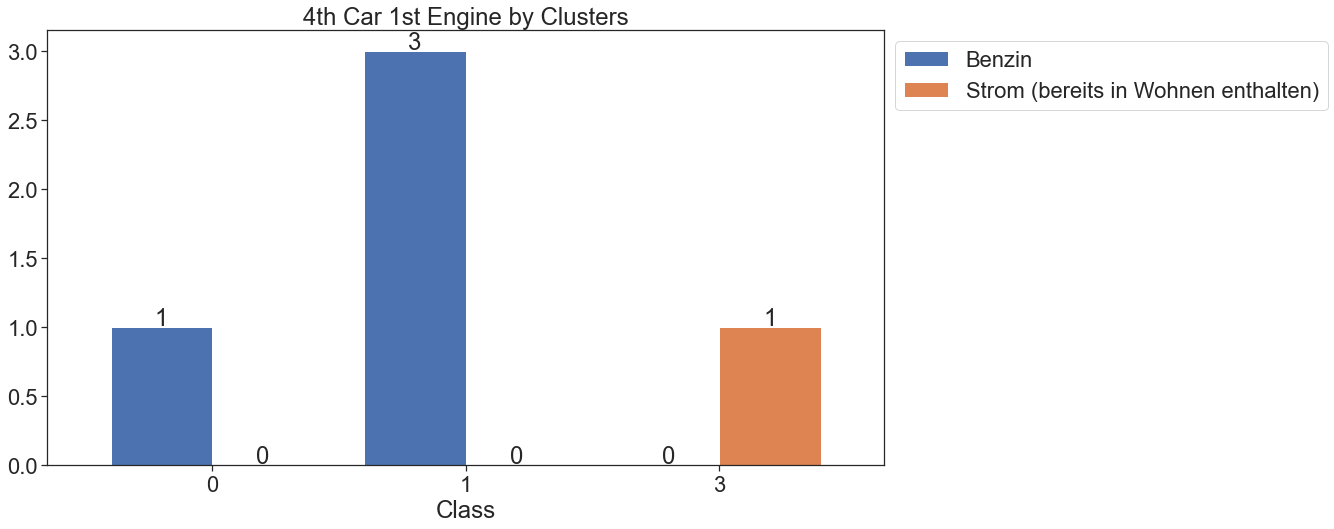

In [68]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_7']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='4th Car 1st Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1, 1))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+0.06),
                ha='center',
                va='center')

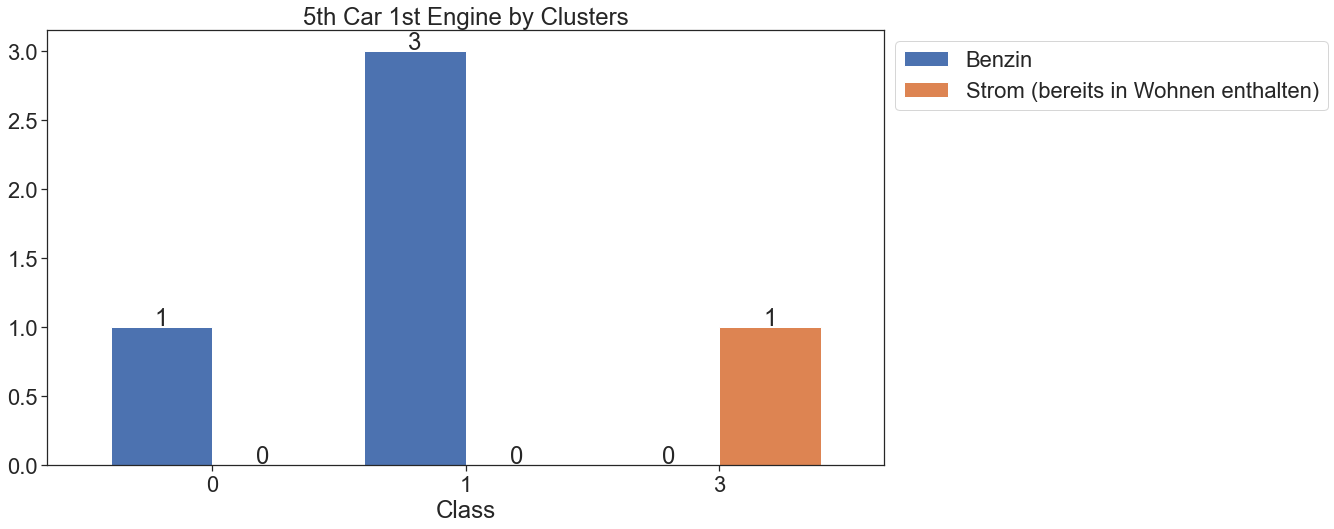

In [69]:
sns.set_style("ticks")


#df2_nonscale['engine_1'] = df2_nonscale['no_cars'].astype('int').astype('object')

ax2 = df2_nonscale.groupby(['cluster_id', 'engine_7']).size().unstack(level=1).plot(kind='bar', figsize=(15,8), width = 0.8, title ='5th Car 1st Engine by Clusters',  xlabel = 'Class')
ax2.legend(bbox_to_anchor=(1, 1))
ax2.tick_params(axis='x', rotation=0)



for p in ax2.patches:
    ax2.annotate(round(p.get_height()),
                xy=(p.get_x()+p.get_width()/2., p.get_height()+0.06),
                ha='center',
                va='center')

In [187]:
## expected results for Class 0
cluster0 = df2_nonscale[df2_nonscale['cluster_id'] == 0]
cluster0.describe()

Unnamed: 0         age       income    CO2_cruise    CO2_flight  \
count   64.000000   64.000000    64.000000     64.000000     64.000000   
mean   239.718750   33.625000  3493.750000   9705.187500   5511.716875   
std    163.329686   13.448904  1864.528963  22273.238668  11962.816461   
min      1.000000   19.000000   400.000000    271.000000      0.000000   
25%    109.750000   24.750000  2000.000000   1084.000000    798.000000   
50%    194.000000   31.000000  3100.000000   1897.000000   2644.040000   
75%    325.750000   38.000000  4500.000000   4268.250000   5725.550000   
max    584.000000  100.000000  8000.000000  98915.000000  91565.800000   

       CO2_public_transport  CO2_car_total   CO2_mobility  \
count             64.000000      64.000000      64.000000   
mean              84.218750    5392.000283   20693.123408   
std               44.916667   14564.186704   32495.980699   
min                0.000000       0.000000     807.319281   
25%              107.800000     143.272800    5171.913750   
50%              107.800000    2639.587500    9902.242500   
75%              107.800000    4230.690750   14222.838750   
max              107.800000   89545.500000  176807.100000   

       belief_diff_mobility  cluster_id  underestimates  engine_8  engine_10  
count             64.000000        64.0       64.000000       0.0        0.0  
mean             -31.859375         0.0        0.890625       NaN        NaN  
std               26.700495         0.0        0.314576       NaN        NaN  
min              -98.000000         0.0        0.000000       NaN        NaN  
25%              -53.250000         0.0        1.000000       NaN        NaN  
50%              -31.000000         0.0        1.000000       NaN        NaN  
75%              -10.750000         0.0        1.000000       NaN        NaN  
max               35.000000         0.0        1.000000       NaN        NaN

In [188]:
## total emission from the car 

df2_nonscale['CO2_car_total'].sum()

1623947.3301610001

In [189]:
cluster0['CO2_car_total'].sum()

345088.018101

In [190]:
## When Class 0 emission from car lowers to the level of CLass 3

round(100*(345088.018101 - (4319.52*64)) / 1623947.3301610001, 2)

4.23

In [191]:
## When Class 0 emission from car lowers to the levle of CLass 3

round(100*(345088.018101 - (3501.75*64)) / 1623947.3301610001, 2)

7.45

In [192]:
## total emission from flights

df2_nonscale['CO2_flight'].sum()

1402588.28

In [193]:
cluster0['CO2_flight'].sum()

352749.88

In [194]:
## When Class 0 emission from flights lowers to the level of Class 1

round(100*(352749.88 - (2965.06*64)) / 1402588.28, 2)

11.62

In [195]:
## expected results for Class 1

cluster1 = df2_nonscale[df2_nonscale['cluster_id'] == 1]
cluster1.describe()

Unnamed: 0         age       income  CO2_cruise    CO2_flight  \
count  176.000000  176.000000   176.000000       176.0    176.000000   
mean   301.522727   33.096591  3820.977273         0.0   2965.058409   
std    168.228381   13.564946  1870.580906         0.0   9700.528625   
min      5.000000   18.000000     0.000000         0.0      0.000000   
25%    158.750000   22.750000  2500.000000         0.0      0.000000   
50%    292.000000   28.500000  4000.000000         0.0    798.000000   
75%    436.000000   40.000000  5000.000000         0.0   2349.500000   
max    587.000000   74.000000  9000.000000         0.0  96159.000000   

       CO2_public_transport  CO2_car_total   CO2_mobility  \
count          1.760000e+02     176.000000     176.000000   
mean           1.078000e+02    4319.520072    7392.378482   
std            3.562850e-13    8611.874756   15522.010316   
min            1.078000e+02       0.000000     110.392810   
25%            1.078000e+02    1074.546000    2315.017000   
50%            1.078000e+02    2149.092000    3867.809000   
75%            1.078000e+02    3612.267500    6367.227000   
max            1.078000e+02   77784.300000  174051.100000   

       belief_diff_mobility  cluster_id  underestimates  engine_8  engine_10  
count            176.000000       176.0      176.000000       0.0        0.0  
mean             -15.556818         1.0        0.698864       NaN        NaN  
std               25.697519         0.0        0.460061       NaN        NaN  
min              -83.000000         1.0        0.000000       NaN        NaN  
25%              -33.000000         1.0        0.000000       NaN        NaN  
50%              -13.000000         1.0        1.000000       NaN        NaN  
75%                3.250000         1.0        1.000000       NaN        NaN  
max               44.000000         1.0        1.000000       NaN        NaN

In [196]:
cluster1['CO2_car_total'].sum()

760235.5327440001

In [197]:
## When Class 1 emission from car lowers to the level of CLass 3

round(100*(760235.5327440001 - (3501.75*176)) / 1623947.3301610001, 2)

8.86